In [1]:
%load_ext autoreload
%autoreload 2

In [2]:

import sys
sys.path = ['/data/mhoffert/tools/ete/'] + sys.path[:-1]
from ete3 import Tree
from ete3.treeview import faces, AttrFace, TextFace, TreeStyle, NodeStyle, CircleFace, RectFace

# python libraries
import pickle
import itertools
import random


# data
import pandas as pd
import numpy as np
import scipy.stats as st
from scipy.spatial import ConvexHull, Delaunay
from sklearn import manifold
from sklearn.utils import check_random_state
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale

# plotting
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.collections import PolyCollection
import matplotlib
import matplotlib.cm as cm
import matplotlib.patches as patches


# statistics
from scipy.signal import find_peaks
from scipy.stats import gaussian_kde
from sklearn.preprocessing import scale
# from skbio.stats.distance import mantel

# additional plotting code
import sys
sys.path.append('/data/mhoffert/fiererlab/periodic_phyla/code/')

from tufte_box import *

# displays
from IPython.display import display, clear_output

import os
os.environ['QT_QPA_PLATFORM']='offscreen'

In [3]:
import matplotlib.cm as cm
from matplotlib.colors import to_hex

In [4]:
from sklearn import svm
from sklearn.datasets import make_blobs

## Outline
A notebook containing code to generate figures.

## Load data

In [5]:
# read in gtdb metadata
md = pd.read_csv('/data/mhoffert/genomes/GTDB_r207/bac120_metadata_r207.tsv', sep='\t')

# filter to representatives
md = md[md.gtdb_representative.eq('t')].copy(deep=True)
md['Phylum'] = md.gtdb_taxonomy.apply(lambda x: x.split(';')[1].split('__')[-1])
md['Class'] = md.gtdb_taxonomy.apply(lambda x: x.split(';')[2].split('__')[-1])
md['Order'] = md.gtdb_taxonomy.apply(lambda x: x.split(';')[3].split('__')[-1])
md['Family'] = md.gtdb_taxonomy.apply(lambda x: x.split(';')[4].split('__')[-1])
md['Genus'] = md.gtdb_taxonomy.apply(lambda x: x.split(';')[5].split('__')[-1])
md['Species'] = md.gtdb_taxonomy.apply(lambda x: x.split(';')[6].split('__')[-1])

# subset to phyla with at least 100 representatives
phylum_counts = md.groupby('Phylum').count()
top_phyla = phylum_counts[phylum_counts['accession'] > 100].index.unique()
md_top_phyla = md[md['Phylum'].isin(top_phyla)].copy(deep=True)

Columns (61,65,74,82,83,85) have mixed types. Specify dtype option on import or set low_memory=False.


In [6]:
# additional columns
phylum_counts = md_top_phyla.groupby('Phylum').count()['accession']
class_counts = md_top_phyla.groupby('Class').count()['accession']

# parsing to make plot of isolate vs. environmental
md_top_phyla['ncbi_genome_category_grouped'] = md_top_phyla['ncbi_genome_category'].apply(lambda x: 'Isolate' if x=='none' else 'MAG/SAG/environmental')

In [7]:
md_top_phyla['accession_reformat'] = md_top_phyla['accession'].apply(lambda x: x.replace('.', '_'))

In [8]:
# get a list of the most abundant phyla
most_abundant_phyla = md_top_phyla.groupby(['Phylum']).count().sort_values('accession', ascending=False).head(10)
print(most_abundant_phyla['accession'])

Phylum
Proteobacteria       17350
Bacteroidota          8588
Firmicutes_A          8243
Actinobacteriota      7328
Firmicutes            4216
Patescibacteria       2485
Chloroflexota         1387
Cyanobacteria         1372
Verrucomicrobiota     1325
Planctomycetota       1071
Name: accession, dtype: int64


In [9]:
md['ncbi_isolation_source'].value_counts()

none                                      56895
soil                                        306
biological product [ENVO:02000043]          171
derived from human gut metagenome           156
not provided; submitted under MIGS 2.1      136
                                          ...  
a paper mill waste water polluted pond        1
soil sediment                                 1
grasslands                                    1
soil of a rice field                          1
host s whole body                             1
Name: ncbi_isolation_source, Length: 2026, dtype: int64

## Figure 1 Placeholder
A conceptual figure describing the workflow

## Figure 2
A figure containing the number of genomes per phylum, the number of isolates, and the completeness

In [9]:
# calculate the fraction of each phylum which is isolates
isolate_percentages = md_top_phyla.groupby(['Phylum', 'ncbi_genome_category_grouped', ]).count()['accession'].unstack()
# old code to normalize
# .divide(md_top_phyla.groupby(['Phylum']).count()['accession'], 0) * 100

# formatting
isolate_percentages = isolate_percentages.reset_index()
isolate_percentages['total'] = isolate_percentages['Isolate'] + isolate_percentages['MAG/SAG/environmental']

isolate_percentages.head()

ncbi_genome_category_grouped            Phylum  Isolate  \
0                              Acidobacteriota       90   
1                             Actinobacteriota     4952   
2                               Armatimonadota        7   
3                                 Bacteroidota     2636   
4                             Bdellovibrionota       29   

ncbi_genome_category_grouped  MAG/SAG/environmental  total  
0                                               783    873  
1                                              2376   7328  
2                                               132    139  
3                                              5952   8588  
4                                               195    224

In [10]:
isolate_percentages

ncbi_genome_category_grouped              Phylum  Isolate  \
0                                Acidobacteriota       90   
1                               Actinobacteriota     4952   
2                                 Armatimonadota        7   
3                                   Bacteroidota     2636   
4                               Bdellovibrionota       29   
5                               Campylobacterota      300   
6                                    Chlamydiota       43   
7                                  Chloroflexota       80   
8                                  Cyanobacteria      507   
9                                   Deinococcota      107   
10                              Desulfobacterota      151   
11                            Desulfobacterota_I      111   
12                               Elusimicrobiota        4   
13                                Fibrobacterota       21   
14                                    Firmicutes     3063   
15                                  Firmicutes_A     1380   
16                                  Firmicutes_B      106   
17                                  Firmicutes_C      135   
18                                  Firmicutes_D        6   
19                                  Firmicutes_G        3   
20                               Gemmatimonadota        6   
21                                Marinisomatota        7   
22                                   Myxococcota       83   
23                                  Nitrospirota       20   
24                                  Omnitrophota        1   
25                               Patescibacteria       34   
26                               Planctomycetota      148   
27                                Proteobacteria     9622   
28                                 Spirochaetota      183   
29                                  Synergistota       25   
30                             Verrucomicrobiota      102   

ncbi_genome_category_grouped  MAG/SAG/environmental  total  
0                                               783    873  
1                                              2376   7328  
2                                               132    139  
3                                              5952   8588  
4                                               195    224  
5                                               250    550  
6                                               128    171  
7                                              1307   1387  
8                                               865   1372  
9                                                37    144  
10                                              788    939  
11                                              125    236  
12                                              185    189  
13                                               99    120  
14                                             1153   4216  
15                                             6863   8243  
16                                              217    323  
17                                              260    395  
18                                               98    104  
19                                              128    131  
20                                              231    237  
21                                              179    186  
22                                              310    393  
23                                              294    314  
24                                              281    282  
25                                             2451   2485  
26                                              923   1071  
27                                             7728  17350  
28                                              512    695  
29                                              107    132  
30                                             1223   1325

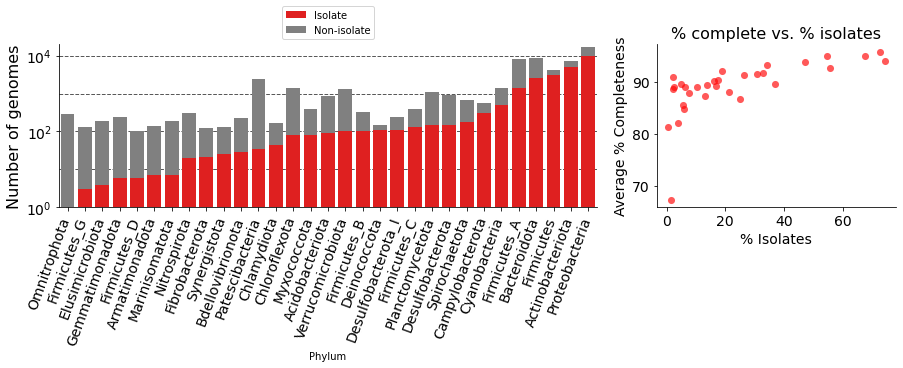

In [11]:
# figure
fig= plt.figure(figsize=(15,3))
gs = gridspec.GridSpec(1, 3, figure=fig)

# plot with bars for total genomes and isolate percentage
ax = fig.add_subplot(gs[0, :2])
sns.barplot(data=isolate_percentages.sort_values('Isolate').reset_index(), 
            y='Isolate', x='Phylum', label='Isolate',
            color='red', zorder=2)

sns.barplot(data=isolate_percentages.sort_values('Isolate').reset_index(), 
            y='total', x='Phylum', label='Non-isolate',
            color='gray', zorder=1)

# formatting
ax.set_yscale('log')
lgd = ax.legend(loc='lower center', 
                bbox_to_anchor=(0.5, 1),
                facecolor='white')
plt.tick_params(labelsize=14)
xticks = plt.xticks(rotation=70, ha='right')
fix_rotation(fig, ax)
sns.despine()
ax.set_ylabel('Number of genomes', fontsize=16)

ax.set_ylim(1e0, 2e4)

# add horizontal guiding lines
for i in np.logspace(0, 4, 5):
    ax.axhline(i, color='k', zorder=0, alpha=0.65, linewidth=1, linestyle='--')
    
    
# plot of isolate % vs completeness
ax = fig.add_subplot(gs[0, 2])

# x data: % of isolates in phylum
x_data = isolate_percentages.set_index('Phylum')['Isolate'].sort_values()
x_data = x_data.divide(md_top_phyla.groupby(['Phylum']).count()['accession'], 0) * 100

# plot
sns.scatterplot(x=x_data, 
                y=md_top_phyla.groupby('Phylum').mean()['checkm_completeness'],
                linewidth=0, alpha=0.65, color='r', s=50,
                ax=ax)

ax.tick_params(labelsize=14)
ax.set_title('% complete vs. % isolates', fontsize=16)
ax.set_ylabel('Average % Completeness', fontsize=14)
ax.set_xlabel('% Isolates', fontsize=14)
sns.despine()

fig.subplots_adjust(wspace=0.25)

# save
# plt.savefig('/data/mhoffert/fiererlab/periodic_phyla/figures/finalized_figures/figure2.png', 
#             dpi=400, bbox_inches='tight', bbox_extra_artists=(lgd,))

# plt.savefig('/data/mhoffert/fiererlab/periodic_phyla/figures/finalized_figures/figure2.svg', 
#             bbox_inches='tight', bbox_extra_artists=(lgd,))

## Figure 3
Large summary figure

### Loading individual data vectors

In [12]:
'''
OXYGEN
'''
oxygen_predictions = pd.read_csv('/data/mhoffert/fiererlab/periodic_phyla/results/full_gtdb_oxygen_predictions.tsv.gz', 
                                 sep='\t', compression='gzip', index_col=0)

plotdf_ox = pd.merge(oxygen_predictions, md_top_phyla, left_index=True, right_on='accession')

In [13]:
'''
CARBON
'''
carbon_predictions = pd.read_csv('/data/mhoffert/fiererlab/periodic_phyla/results/full_gtdb_carbon_fixation_v2.tsv.gz',
                                sep='\t', compression='gzip', index_col=0)

In [14]:
'''
PHOTOSYNTHESIS
'''
photosynthesis_predictions = pd.read_csv('/data/mhoffert/fiererlab/periodic_phyla/results/full_gtdb_photosynthesis_predictions_v2.tsv.gz',
                                        compression='gzip', sep='\t', index_col=0).rename(columns={'0':'phototroph'})
photosynthesis_predictions.head(2)

phototroph
accession                     
GB_GCA_000012145.1       False
GB_GCA_000024525.1        True

In [15]:
'''
GROWTH RATE
'''
# load gRodon growth rate data
growth_rates = pd.read_csv('/data/mhoffert/fiererlab/periodic_phyla/results/gRodon_full_results_table.tsv.gz', 
                           compression='gzip', sep='\t', index_col=0)

# # merge with genome metadata
# growth_rate_plotdf = pd.merge(md_top_phyla, growth_rates, left_on='accession', right_index=True, how='left')

In [16]:
df_dict =  {'aerobe':oxygen_predictions['aerobe'], 
           'phototroph':photosynthesis_predictions['phototroph'].astype(int), 
           'carbon_fixation':carbon_predictions, 
           'growth_rate':growth_rates['d'].rename('growth_rate'), 
           'genome_size':md.set_index('accession')['genome_size'],
           'gc_percentage':md.set_index('accession')['gc_percentage']}

In [17]:
pca_data = pd.concat([df_dict[l] for l in df_dict.keys()], axis=1, sort=True).dropna()
test_plot_data = pd.merge(md_top_phyla[['accession', 'Phylum']], pca_data, left_on='accession', right_index=True)

In [18]:
stacked_test_data = test_plot_data.set_index(['Phylum', 'accession']).stack().reset_index()

In [19]:
test_plot_data = test_plot_data[test_plot_data.growth_rate < 20]

In [20]:
y_order = test_plot_data.sort_values('Phylum').groupby('Phylum').mean()[['aerobe','gc_percentage']].rank().mean(1).sort_values().index

In [21]:
# plot_data.iloc[:, [0,1,4,5,6,7,8,9]].groupby('Phylum').sum().divide(phylum_counts, 0)

Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
Dataset has 0 variance; skipping density estimate. Pass `warn_singular=Fa

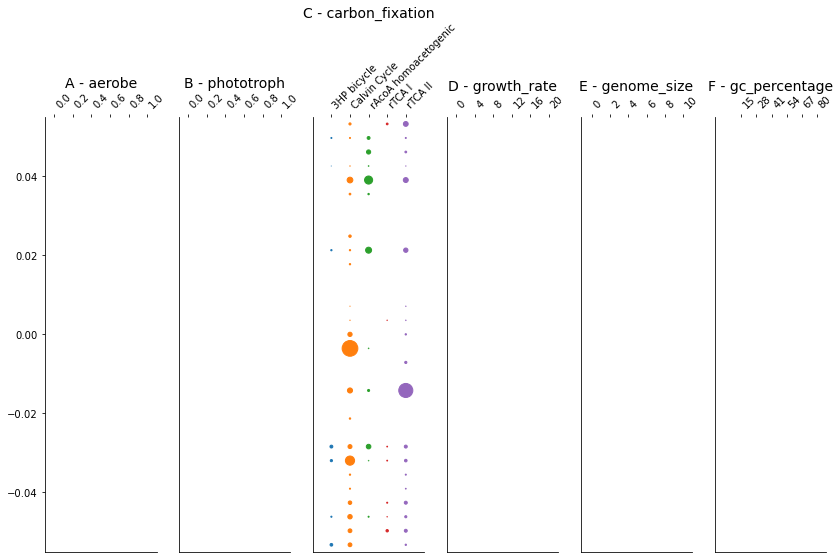

In [22]:
fig = plt.figure(figsize=(14, 8))
i =  1
plot_data = test_plot_data.sort_values('Phylum')

for col, cmap, x_max, plot_label in zip(['aerobe', 'phototroph', 'carbon_fixation','growth_rate','genome_size','gc_percentage'],
                     ['Reds', 'Blues', 'Oranges', 'Greens',  'Greys', 'Purples'],
                     [1, 1, 1, 20, 1e7, 80],
                     ['A', 'B', 'C', 'D', 'E', 'F']):
    
    ax = fig.add_subplot(1, 6, i)

    
    if col != 'carbon_fixation':
    
        norm = matplotlib.colors.Normalize(vmin=test_plot_data[col].min(), 
                                           vmax=test_plot_data[col].max(), clip=True)

        mapper = cm.ScalarMappable(norm=norm, cmap=cmap)
        phylum_means = plot_data.groupby('Phylum').mean()[col].reindex(y_order)
        palette = [mapper.to_rgba(p) for p in phylum_means.values]
        
        for phylum_ind, phylum in enumerate(y_order):
            g = sns.kdeplot(data=plot_data[['Phylum', col]], 
                           y=phylum_ind, 
                           x=col,
                           scale='width',
                           inner=None,
                           # hue=True,
                           # hue_order=[True, False],
                           #split=True, 
                           palette=palette, 
                           order=y_order,
                            # cut=0

                      )
    else:
        phylum_counts = plot_data.Phylum.value_counts()
        carbon_fixation_phylum_counts = plot_data.iloc[:, [0,1,4,5,6,7,8,9]].groupby('Phylum').sum().divide(phylum_counts, 0)
        cf_plotdf = carbon_fixation_phylum_counts.stack().reset_index()
        cycles = ['3HP bicycle','Calvin Cycle', 'rAcoA homoacetogenic','rTCA I', 'rTCA II']
        for j, c in enumerate(cycles):

            sizes = cf_plotdf[cf_plotdf['level_1'].eq(c)].set_index('level_0').reindex(y_order)[0].values
            ys = list(range(len(y_order)))
            xs = [j] * len(y_order)
            plt.scatter(xs, ys[::-1], s=sizes * 400)
            
    ax.set_xlabel(f'{plot_label} - {col}', fontsize=14)
    ax.xaxis.set_label_position('top') 
    
    # violin plot quartiles
    for l in ax.lines:
        l.set_linestyle('-')
        l.set_linewidth(1)
        l.set_color('white')
    
    # ticks
    plt.tick_params(top=True)
    ax.xaxis.tick_top()
    
    # remove legend
    if not ax.get_legend() is None:
        ax.get_legend().remove()
        
    # no edge on violins
    # for art in ax.get_children():
    #     if isinstance(art, PolyCollection):
    #         art.set_edgecolor((0, 0, 0))
    #         art.set_linewidth(1)
    # remove axis labels
    if i > 1:
        ax.get_yaxis().set_visible(False)
    
    # format top ticks
    if not col in ['genome_size', 'carbon_fixation']:
        ax.set_xticks([float(f'{i:.1f}') for i in np.linspace(int(np.floor(plot_data[col].min())), x_max, 6)])
    else:
        if col != 'carbon_fixation':
            ax.set_xticks([i for i in np.linspace(int(np.floor(plot_data[col].min())), x_max, 6)])
            ax.set_xticklabels([f'{int(i) / 1e6:.0f}' for i in np.linspace(int(np.floor(plot_data[col].min())), x_max, 6)])
    
    plt.xticks(rotation=45, ha='left', va='bottom')
    # fix_rotation(fig, ax)
    
    if col != 'carbon_fixation':
        
        new_x_bottom, new_x_top = -x_max * 0.1, x_max * 1.1 
        ax.set_xlim(new_x_bottom, new_x_top)

        num_y_ticks = len(plot_data['Phylum'].unique())
        for box_y in range(num_y_ticks):
            ''
            rect = patches.Rectangle((-0.2, box_y + 0.03), (new_x_top - new_x_bottom), 0.5, linewidth=1, edgecolor='white', facecolor='white')
            ax.add_patch(rect)
            
    else:
        ax.set_xlim(-1, 5)
        ax.set_ylim(-0.5, 30.5)
        ax.set_xticks(range(len(cycles)))
        ax.set_xticklabels(cycles)
        
    # ax.axhline(0)
    # ax.axhline(30)
    # ------------------------------------------------------------    
    ### PEAK FINDING
    # ------------------------------------------------------------
#     if col != 'carbon_fixation':
#         y_tick_loc = 0
#         for y_tick in y_order:
#             peak_data = plot_data[plot_data['Phylum'] == y_tick]

#             peak_kde = gaussian_kde(peak_data[col], bw_method='scott')
#             xx = np.linspace(new_x_bottom, new_x_top, 100)
#             kde_y = scale(np.array([0] + [peak_kde.integrate_box_1d(xx[i], xx[i+1]) for i in range(len(xx)-1)])) / 5
#             peaks, _ = find_peaks(kde_y, height=1e-2, prominence=(0.001, 1))

#             # fig, ax = plt.subplots(figsize=(6, 4))
#             # plt.plot(xx, y_tick_loc - kde_y)
#             plt.plot(xx[peaks],  [y_tick_loc] * len(peaks), '|', color='k')
#             if len(peaks) > 1:
#                 label_shift = 0.21
#                 for p in peaks:
#                     upper = xx[p] * 1.2
#                     lower = xx[p] * 0.8
#                     peak_counts = md_top_phyla.set_index('accession').loc[peak_data[(peak_data[col] < upper) & (peak_data[col] > lower)]['accession'].unique()]['Order'].value_counts()
#                     if len(peak_counts) > 0:

#                         top_peak_count = peak_counts.iloc[0] / peak_counts.sum()
#                         label = f'{peak_counts.index[0]}: {top_peak_count * 100:.1f}%'
#                         ax.annotate(label, 
#                                     (xx[p], y_tick_loc + label_shift),
#                                     ha='center', fontsize=8)
#                     else:
#                         print(peak_counts, upper, lower)

#                     label_shift += 0.15
#             y_tick_loc += 1
    
    sns.despine()
    i += 1
    
# plt.savefig('/data/mhoffert/fiererlab/periodic_phyla/figures/finalized_figures/combined_figure.png', 
#             dpi=400,
#             bbox_inches='tight')

# plt.savefig('/data/mhoffert/fiererlab/periodic_phyla/figures/finalized_figures/combined_figure.svg', 
#             bbox_inches='tight')

In [23]:
summary_heatmap = pd.DataFrame(index=test_plot_data['Phylum'].unique(), columns=['aerobe', 'photo', 'carbon', 'growth', 'genome_size', 'gc_percentage']).fillna(0)
for phylum in test_plot_data['Phylum'].unique():
    frac_aerobe = (test_plot_data[test_plot_data['Phylum'].eq(phylum)]['aerobe'] >= 0.5).sum() / phylum_counts.loc[phylum]

    

        
    frac_photo = (test_plot_data[test_plot_data['Phylum'].eq(phylum)]['phototroph'] >= 0.5).sum() / phylum_counts.loc[phylum]

    frac_carbon = (test_plot_data[test_plot_data['Phylum'].eq(phylum)].iloc[:, 4:10].sum(1) > 0).sum() / phylum_counts.loc[phylum]

    frac_growth = (test_plot_data[test_plot_data['Phylum'].eq(phylum)]['growth_rate'] >= 5).sum() / phylum_counts.loc[phylum]

    frac_genome = (test_plot_data[test_plot_data['Phylum'].eq(phylum)]['genome_size'] >= 3e10).sum() / phylum_counts.loc[phylum]

    frac_gc = (test_plot_data[test_plot_data['Phylum'].eq(phylum)]['gc_percentage'] >= 50).sum() / phylum_counts.loc[phylum]
    
    summary_heatmap.loc[phylum, 'aerobe'] = frac_aerobe
    summary_heatmap.loc[phylum, 'carbon'] = frac_carbon
    summary_heatmap.loc[phylum, 'photo'] = frac_photo
    # summary_heatmap.loc[phylum, 'growth'] = frac_growth
    summary_heatmap.loc[phylum, 'gc_percentage'] = frac_gc
    # summary_heatmap.loc[phylum, 'genome_size'] = frac_genome


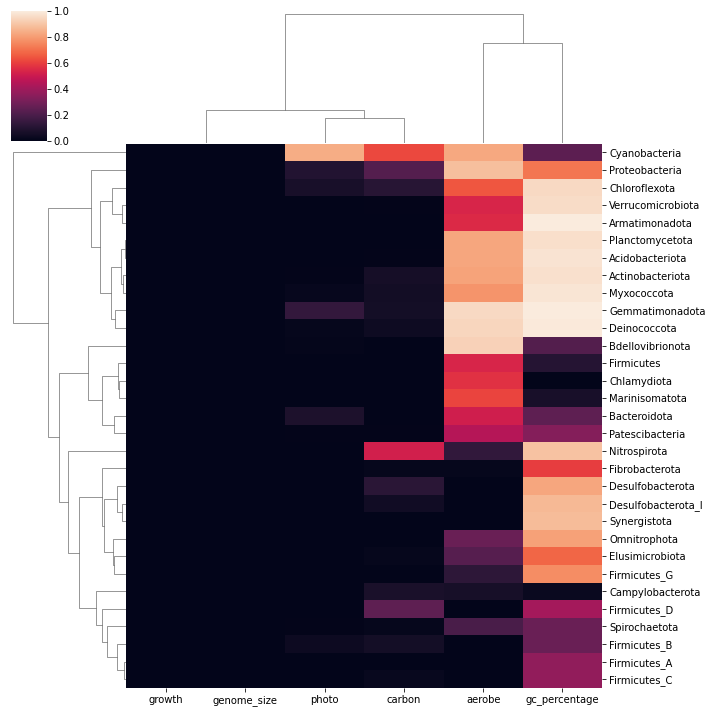

In [24]:
g = sns.clustermap(summary_heatmap)
y_order = [s.get_text() for s in g.ax_heatmap.get_yticklabels()]

In [25]:
with open('/data/mhoffert/fiererlab/periodic_phyla/results/20230816_y_order.txt', 'w') as handle:
    handle.write('\n'.join(y_order))

In [26]:
with open('/data/mhoffert/fiererlab/periodic_phyla/results/20230816_figure3_data.pickle', 'wb') as out_handle:
    pickle.dump(test_plot_data, out_handle)

In [31]:
len(md_top_phyla['Genus'].unique())

14069

## Figure 4 placeholder for phylocorrelograms

## Figure 5 ENS-t-SNE

### Imports

In [115]:
import sys

sys.path.append('/data/mhoffert/tools/MPSE-TSNE/ENS-t-SNE/')

import mview

from sklearn.metrics.pairwise import pairwise_distances
import hdbscan

import matplotlib.cm as cm

In [76]:
import mantel

from scipy.spatial.distance import cdist

In [33]:
pca_data = pd.concat([df_dict[l] for l in df_dict.keys()], axis=1, sort=True).dropna()

In [34]:
with open('/data/mhoffert/fiererlab/periodic_phyla/results/20230814_pca_data.pickle', 'wb') as out_handle:
    pickle.dump(pca_data, out_handle)

### Constructing trait data

In [13]:
with open('/data/mhoffert/fiererlab/periodic_phyla/results/20230814_pca_data.pickle', 'rb') as handle:
    pca_data = pickle.load(handle)

In [14]:
pca_data.index = [i.replace('.', '_') for i in pca_data.index]

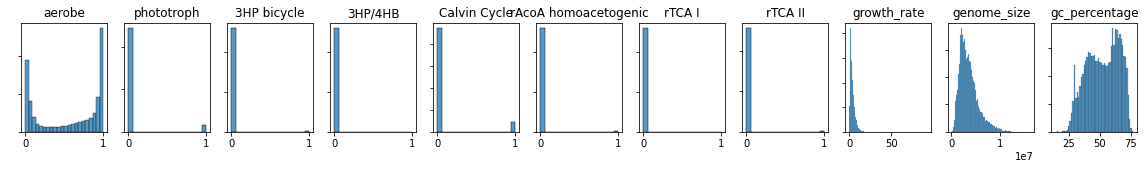

In [15]:
'''
Identify candidate data points for removal
'''
fig = plt.figure(figsize=(20,2))
i = 1
for col in pca_data.columns:
    ax = fig.add_subplot(1, len(pca_data.columns), i)
    # print(list(df_dict.keys())[i])
    sns.histplot(pca_data[col], ax=ax)
    ax.set_ylabel(' ')
    ax.set_xlabel(' ')
    plt.tick_params(labelleft=False)
    ax.set_title(col)
    # plt.show()
    i += 1

Looks like some things need to be filtered based on growth rate

In [16]:
print(pca_data.shape)
pca_data = pca_data[pca_data['growth_rate'] < 25]
print(pca_data.shape)

(51880, 11)
(51851, 11)


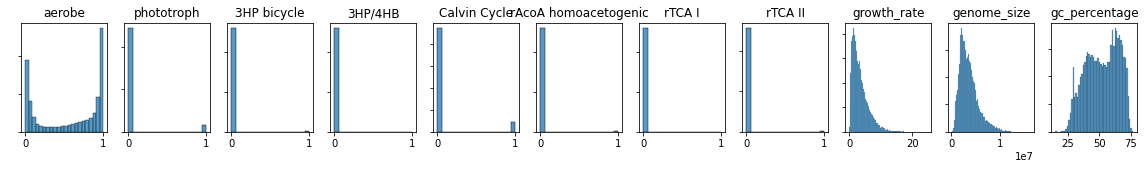

In [17]:
'''
Identify candidate data points for removal
'''
fig = plt.figure(figsize=(20,2))
i = 1
for col in pca_data.columns:
    ax = fig.add_subplot(1, len(pca_data.columns), i)
    # print(list(df_dict.keys())[i])
    sns.histplot(pca_data[col], ax=ax)
    ax.set_ylabel(' ')
    ax.set_xlabel(' ')
    plt.tick_params(labelleft=False)
    ax.set_title(col)
    # plt.show()
    i += 1

### Leaf distance matrix

In [18]:
%%time
with open('/data/mhoffert/fiererlab/periodic_phyla/results/trees/GTDB_full_tip_dist_matrix_np.pickle', 'rb') as handle:
    distance_matrix = pickle.load(handle)

CPU times: user 0 ns, sys: 8.06 s, total: 8.06 s
Wall time: 8.08 s


In [19]:
with open('/data/mhoffert/fiererlab/periodic_phyla/results/trees/GTDB_full_tip_dist_matrix_rownames.txt', 'r') as handle:
    row_names_lines = handle.readlines()

row_names = [r.strip().replace('"', '') for r in row_names_lines[1:]]
row_names_series = pd.Series(row_names)

In [20]:
# list of genomes in phyla with at least 100 representatives
top_phyla_genome_accs = md_top_phyla['accession_reformat'].unique()

# vector of T/F for leaves in the trait data used to subset distance matrix
keep_rows = np.array([r in pca_data.index and r in top_phyla_genome_accs for r in row_names])

# same as above, used to reindex trait data
keep_rows_names = np.array([r for r in row_names if r in pca_data.index and r in top_phyla_genome_accs])

In [21]:
len(keep_rows_names), np.sum(keep_rows)

(50745, 50745)

In [22]:
patristic_distance_matrix = distance_matrix[keep_rows, :][:, keep_rows]

In [23]:
# testing code
def scale_func(x, xname):
    print(f'scaling {xname}')
    return scale(x)

to_scale_vars = ['growth_rate', 'genome_size', 'gc_percentage']
pca_data.head().apply(lambda x: scale_func(x, x.name) if x.name in to_scale_vars else x)

scaling growth_rate
scaling genome_size
scaling gc_percentage


aerobe  phototroph  3HP bicycle  3HP/4HB  Calvin Cycle  \
GB_GCA_000007325_1  0.001817           0          0.0      0.0           0.0   
GB_GCA_000008885_1  0.470498           0          0.0      0.0           0.0   
GB_GCA_000009845_1  0.682832           0          0.0      0.0           0.0   
GB_GCA_000010085_1  0.865893           0          0.0      0.0           0.0   
GB_GCA_000010565_1  0.018416           0          0.0      0.0           0.0   

                    rAcoA homoacetogenic  rTCA I  rTCA II  growth_rate  \
GB_GCA_000007325_1                   0.0     0.0      0.0     0.556748   
GB_GCA_000008885_1                   0.0     0.0      0.0     0.735718   
GB_GCA_000009845_1                   0.0     0.0      0.0     1.045784   
GB_GCA_000010085_1                   0.0     0.0      0.0    -1.569988   
GB_GCA_000010565_1                   0.0     0.0      0.0    -0.768261   

                    genome_size  gc_percentage  
GB_GCA_000007325_1    -0.026066      -0.710654  
GB_GCA_000008885_1    -1.115905      -1.049117  
GB_GCA_000009845_1    -1.004745      -0.666624  
GB_GCA_000010085_1     1.542596       1.269066  
GB_GCA_000010565_1     0.604120       1.157329

In [24]:
np_pca_data = pca_data.apply(lambda x: scale_func(x, x.name) if x.name in to_scale_vars else x).reindex(keep_rows_names).astype(float)

scaling growth_rate
scaling genome_size
scaling gc_percentage


In [25]:
np_pca_data

aerobe  phototroph  3HP bicycle  3HP/4HB  Calvin Cycle  \
GB_GCA_012517545_1  0.012481         0.0          0.0      0.0           0.0   
GB_GCA_017540815_1  0.008260         0.0          0.0      0.0           0.0   
GB_GCA_001829125_1  0.046911         0.0          0.0      0.0           0.0   
GB_GCA_009784515_1  0.081483         0.0          0.0      0.0           0.0   
GB_GCA_016936615_1  0.052110         0.0          0.0      0.0           0.0   
...                      ...         ...          ...      ...           ...   
GB_GCA_002343545_1  0.657668         0.0          0.0      0.0           0.0   
GB_GCA_018266335_1  0.772987         0.0          0.0      0.0           0.0   
GB_GCA_009991595_1  0.681081         0.0          0.0      0.0           0.0   
GB_GCA_018001635_1  0.671488         0.0          0.0      0.0           0.0   
GB_GCA_001799195_1  0.146793         0.0          0.0      0.0           0.0   

                    rAcoA homoacetogenic  rTCA I  rTCA II  growth_rate  \
GB_GCA_012517545_1                   0.0     0.0      0.0    -0.120779   
GB_GCA_017540815_1                   0.0     0.0      0.0    -0.867855   
GB_GCA_001829125_1                   0.0     0.0      0.0     0.404638   
GB_GCA_009784515_1                   0.0     0.0      0.0     0.767524   
GB_GCA_016936615_1                   0.0     0.0      0.0    -0.436930   
...                                  ...     ...      ...          ...   
GB_GCA_002343545_1                   0.0     0.0      0.0    -0.407805   
GB_GCA_018266335_1                   0.0     0.0      0.0    -0.829250   
GB_GCA_009991595_1                   0.0     0.0      0.0    -0.105562   
GB_GCA_018001635_1                   0.0     0.0      0.0    -0.078273   
GB_GCA_001799195_1                   0.0     0.0      0.0    -0.168174   

                    genome_size  gc_percentage  
GB_GCA_012517545_1    -0.637998      -1.708150  
GB_GCA_017540815_1    -0.264948      -0.797864  
GB_GCA_001829125_1     0.426372      -1.989249  
GB_GCA_009784515_1    -0.915710      -0.887366  
GB_GCA_016936615_1    -0.170182      -1.136206  
...                         ...            ...  
GB_GCA_002343545_1    -0.111175       0.896093  
GB_GCA_018266335_1     0.110383       0.253868  
GB_GCA_009991595_1    -0.325761      -0.649148  
GB_GCA_018001635_1    -0.382938      -0.984238  
GB_GCA_001799195_1     0.551730       0.648343  

[50745 rows x 11 columns]

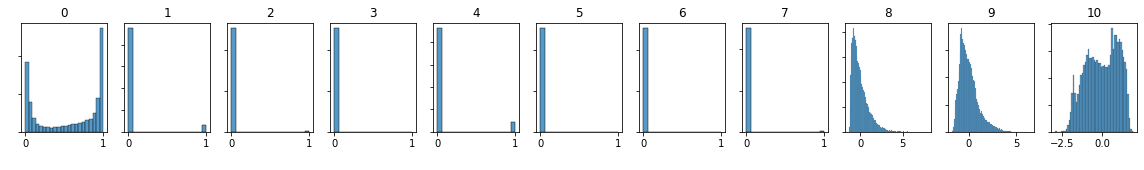

In [26]:
'''
plotting scaled data
'''
fig = plt.figure(figsize=(20,2))
i = 1
for col in range(len(pca_data.columns)):
    ax = fig.add_subplot(1, len(pca_data.columns), i)
    # print(list(df_dict.keys())[i])
    sns.histplot(np_pca_data.values[:, col], ax=ax)
    ax.set_ylabel(' ')
    ax.set_xlabel(' ')
    plt.tick_params(labelleft=False)
    ax.set_title(col)
    # plt.show()
    i += 1

In [27]:
np_pca_data.shape, patristic_distance_matrix.shape

((50745, 11), (50745, 50745))

### Loading in the tree

In [28]:
gtdb_full = Tree('/data/mhoffert/genomes/GTDB_r207/tree/bac120_r207.tree', format=1, quoted_node_names=True)

### Reformatting tree

In [29]:
# rename internal nodes
names_map = []
i = 0
for node in gtdb_full.traverse(strategy='levelorder'):
    if i % 500 == 0:
        display(i)
        clear_output(wait=True)
    if not node.is_leaf():
        new_node_name = f'c{i:06}'
        names_map.append((new_node_name, node.name))
        node.name = new_node_name
    else:
        names_map.append((node.name.replace('.', '_'), node.name))
        node.name = node.name.replace('.', '_')
    i += 1

124500

In [30]:
# make a series
names_map = pd.Series(dict(names_map))

In [31]:
phylum_counts

Phylum
Acidobacteriota         873
Actinobacteriota       7328
Armatimonadota          139
Bacteroidota           8588
Bdellovibrionota        224
Campylobacterota        550
Chlamydiota             171
Chloroflexota          1387
Cyanobacteria          1372
Deinococcota            144
Desulfobacterota        939
Desulfobacterota_I      236
Elusimicrobiota         189
Fibrobacterota          120
Firmicutes             4216
Firmicutes_A           8243
Firmicutes_B            323
Firmicutes_C            395
Firmicutes_D            104
Firmicutes_G            131
Gemmatimonadota         237
Marinisomatota          186
Myxococcota             393
Nitrospirota            314
Omnitrophota            282
Patescibacteria        2485
Planctomycetota        1071
Proteobacteria        17350
Spirochaetota           695
Synergistota            132
Verrucomicrobiota      1325
Name: accession, dtype: int64

## Plotting phylum selection to try to find conserved clades of microbes

In [184]:
def get_num_leaves(n):
    return len(n.get_leaves())

def collapseTree_size(tree,  n_leaves): # add to ete utils
    #is there a better way to collapse that preserves properties?
    t = Tree(tree.write(is_leaf_fn=lambda n: collapseClades_size(n, n_leaves), format=3),format=3) 
    t.name = tree.name
    return t

def collapseClades_size(node, leaf_count):
    '''collapses clades below max_leaf_dist. can be passed as is_leaf_fn'''
    if node.is_leaf():
        return True
    else:
        return 'p__' in names_map.loc[node.name] # n_leaves = len(node.get_leaves())
        # return n_leaves <= leaf_count
            
        # fit tsne
        
node_size_cmap = cm.get_cmap('gnuplot')

def layout_collapsed(node):
    # print(node.name)
                

    internal_ns = NodeStyle()
    internal_ns['size'] = 0
    
    if node.is_leaf():
        
        new_name = names_map.loc[node.name].split(':')[-1].split(';')[-1].lstrip()
        
#         faces.add_face_to_node(TextFace(f" {new_name}", fsize=6), node, column=0)
        num_leaves = len(gtdb_full.search_nodes(name=node.name)[0].get_leaves())
    
        face_color='k'
        if num_leaves >= 1900:
            
            face_color='red'
            
        # face_color = node_size_cmap(len(node.get_leaves()) / 2000)
        R1 = RectFace(width=num_leaves / 100,
                      height=3, 
              fgcolor=face_color,
              bgcolor=face_color)
        faces.add_face_to_node(R1, node, 2, position='aligned')

        
        internal_ns['fgcolor'] = face_color
        internal_ns['size'] = 5

    node.img_style = internal_ns

ts = TreeStyle()
ts.mode = 'c'
ts.layout_fn = layout_collapsed
ts.scale=200
ts.show_leaf_name = False
ts.draw_guiding_lines = False

In [11]:
gtdb_pruned = gtdb_full.copy()

NameError: name 'gtdb_full' is not defined

In [ ]:
gtdb_pruned.prune(np_pca_data.index)

In [ ]:
gtdb_pruned.describe()

In [253]:
def collapse_tree_phylum(tree): # add to ete utils
    #is there a better way to collapse that preserves properties?
    t = Tree(tree.write(is_leaf_fn=lambda n: collapse_to_phylum(n), format=3),format=3) 
    t.name = tree.name
    return t

def collapse_to_phylum(node):
    '''collapses clades below max_leaf_dist. can be passed as is_leaf_fn'''
    value = False
    leaf_value = False
    if node.is_leaf():
        leaf_value = True
        value = True
    else:
        if 'p__' in names_map.loc[node.name]:
            # print(node.name, names_map.loc[node.name])
            value = True
        else:
            value = False
    # print(node.name, value, leaf_value)
    return value

def layout_collapsed(node):
    # print(node.name)
                

    internal_ns = NodeStyle()
    internal_ns['size'] = 0
    
    if node.is_leaf():
        
        new_name = names_map.loc[node.name].split(':')[-1].split(';')[0].lstrip()
        
        faces.add_face_to_node(TextFace(f" {new_name}", fsize=6), node, column=0)
        
        num_leaves = len(gtdb_full.search_nodes(name=node.name)[0].get_leaves())
        faces.add_face_to_node(TextFace(f"{num_leaves}", fsize=6), node, column=1, position='aligned')
    
        face_color='k'
        if num_leaves >= 1900:
            
            face_color='red'
            
        # face_color = node_size_cmap(len(node.get_leaves()) / 2000)
        R1 = RectFace(width=num_leaves / 100,
                      height=3, 
              fgcolor=face_color,
              bgcolor=face_color)
        faces.add_face_to_node(R1, node, 2, position='aligned')

        
        internal_ns['fgcolor'] = face_color
        internal_ns['size'] = 5

    node.img_style = internal_ns

ts = TreeStyle()
# ts.mode = 'c'
ts.layout_fn = layout_collapsed
ts.scale=400
ts.show_leaf_name = False
ts.draw_guiding_lines = False

In [238]:
collapsed_phylum = collapse_tree_phylum(gtdb_pruned)

In [246]:
collapsed_phylum.prune([c for c in collapsed_phylum.get_leaves() if names_map.loc[c.name].split(':')[-1].split(';')[0].lstrip('p_') in top_phyla])

In [247]:
collapsed_phylum.describe()

Number of leaf nodes:	31
Total number of nodes:	61
Rooted:	Yes
Most distant node:	c008059
Max. distance:	0.569670


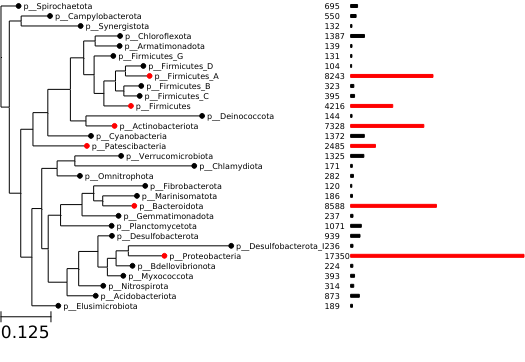

In [254]:
collapsed_phylum.render('%%inline', tree_style=ts)

## Code plan

1. Randomly select leaves in the tree to perform individual ENS-t-SNE
2. Select nodes via collapsing method
3. Create consensus for entire tree using nodes indicated common ancestors of conserved trait groups (CACTG)
4. Summarize trait distribution for each consensus CACTG
5. Identify closest taxonomic assignment of trait groups
6. Create table representing each CACTG

##  Per-phylum ENS-t-SNE

In [255]:
names_map[names_map.str.contains('Synergistota')]

c000123    100.0:p__Synergistota
dtype: object

In [361]:
ancestor = gtdb_pruned.search_nodes(name='c000083')[0].get_ancestors()[1]

In [362]:
ancestor

Tree node 'c000027' (0x7f6acb659ae)

In [363]:
ancestor.get_distance(target='c000123', topology_only=True)

3.0

In [364]:
def depthPrune(n, dist, thresh):
    if n.is_leaf():
        return True
    else:
        return dist >= thresh
            

ancestor_pruned = Tree(ancestor.write(is_leaf_fn=lambda n: depthPrune(n, ancestor.get_distance(target=n, topology_only=True), 5), format=3), format=3)

In [365]:
ancestor_pruned.describe()

Number of leaf nodes:	51
Total number of nodes:	101
Rooted:	Yes
Most distant node:	GB_GCA_014384545_1
Max. distance:	1.468600


In [366]:
def layout_collapsed(node):
    # print(node.name)
                

    internal_ns = NodeStyle()
    internal_ns['size'] = 0
    

    if 'p__' in names_map.loc[node.name]:
        new_name = names_map.loc[node.name].split(':')[-1].split(';')[0].lstrip()
        faces.add_face_to_node(TextFace(f" {new_name}", fsize=6), node, column=0)

        
    node.img_style = internal_ns
        

ts = TreeStyle()
# ts.mode = 'c'
ts.layout_fn = layout_collapsed
# ts.scale=400
ts.show_leaf_name = False
ts.draw_guiding_lines = False

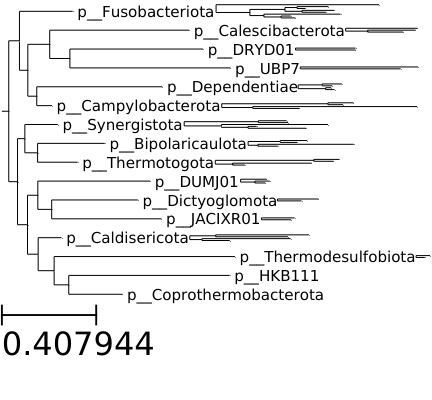

In [367]:
ancestor_pruned.render('%%inline', tree_style=ts, h=400)

In [315]:
[names_map.loc[node.name] for node in gtdb_pruned.search_nodes(name='c000123')[0].get_ancestors()[2].get_children()] #[-1].get_children()

['0.0', '9.0']

In [312]:
names_map.loc['c000182']

'100.0:p__Thermotogota; c__Thermotogae'

In [256]:
# pick a small phylum to test
test_clade = gtdb_full.search_nodes(name='c000123')[0].copy()

In [257]:
test_clade.describe()

Number of leaf nodes:	132
Total number of nodes:	263
Rooted:	Yes
Most distant node:	GB_GCA_017448375_1
Max. distance:	1.525900


## Iteration over phyla to collect data on optimization

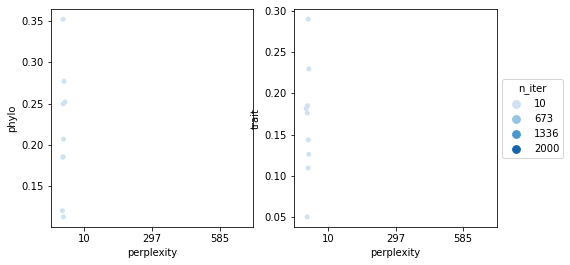

10 10 10
(585, 585)
(585, 11)
len 1
len 1


In [ ]:
for phylum in [['Synergistota', 'Campylobacterota']]:
    print(phylum)
    accs = md_top_phyla[md_top_phyla['Phylum'].isin(phylum)]['accession_reformat'].values
    # subset to ids in our data already
    ids = [i for i in accs if i in np_pca_data.index]
    print(len(accs), len(ids))

iters = np.linspace(10, 2000, 4, dtype=int)
perps = np.linspace(10, len(ids), 3, dtype=int)
n_reps = 50
reps = list(range(1, n_reps))
tsne_opt = pd.DataFrame(index=pd.MultiIndex.from_product([iters, perps, reps], names=['iterations', 'perplexity', 'rep']),
                       columns=['phylo', 'trait'])

# performing t-SNE on phylum and clustering
for phylum in [['Synergistota', 'Campylobacterota']]:
    print(phylum)
    accs = md_top_phyla[md_top_phyla['Phylum'].isin(phylum)]['accession_reformat'].values
    # subset to ids in our data already
    ids = [i for i in accs if i in np_pca_data.index]
    print(len(accs), len(ids))

    # vector of T/F for leaves in the trait data used to subset distance matrix
    phylum_keep_rows = np.array([r in ids for r in row_names])

    # same as above, used to reindex trait data
    phylum_keep_rows_names = np.array([r for r in row_names if r in ids])

    # get distance matrix
    phylum_dist_matrix = distance_matrix[phylum_keep_rows, :][:, phylum_keep_rows]

    # get trait data
    phylum_pca_data = np_pca_data.reindex(index=phylum_keep_rows_names)
    # phylum_pca_data = phylum_pca_data.loc[:, phylum_pca_data.sum() != 0]
    for iters, perp, rep in itertools.product(iters, perps, reps):
        print(iters, perp, rep)
        # perform t-SNE
        phylum_tsne = mview.mpse_tsne(data=[phylum_dist_matrix, phylum_pca_data.values],
                         perplexity=perp,
                         iters=iters,
                         smart_init=True,
                         verbose=0,
                         show_plots=False)

        # Mantel test for perplexity optimization
        image1_phylo_df = pd.DataFrame(index=phylum_keep_rows_names,
                                   columns=['x', 'y'], 
                                   data=phylum_tsne.images[0, :, :])

        image2_trait_df = pd.DataFrame(index=phylum_keep_rows_names,
                                       columns=['x', 'y'],
                                       data=phylum_tsne.images[1, :, :])

        # mantel test on trait distances
        tsne_trait_square = cdist(image2_trait_df, image2_trait_df)
        trait_dist_square = cdist(phylum_pca_data, phylum_pca_data)

        trait_dist_square_df = pd.DataFrame(index=phylum_keep_rows_names, columns=phylum_keep_rows_names, 
                                           data=trait_dist_square).reindex(index=image2_trait_df.index, columns=image2_trait_df.index).values

        trait_results = mantel.test(tsne_trait_square, trait_dist_square_df)

        # mantel test on phylogenetic distances
        tsne_phylo_square = cdist(image1_phylo_df, image1_phylo_df)

        phylum_dists_reindexed = pd.DataFrame(index=phylum_keep_rows_names, columns=phylum_keep_rows_names,
                     data=phylum_dist_matrix).reindex(index=image1_phylo_df.index, columns=image1_phylo_df.index).values

        phylo_results = mantel.test(tsne_phylo_square, phylum_dists_reindexed)

        tsne_opt.loc[(iters, perp, rep), 'phylo'] = phylo_results.r
        tsne_opt.loc[(iters, perp, rep), 'trait'] = trait_results.r
        
        clear_output(wait=True)
        fig = plt.figure(figsize=(8, 4))
        ax = fig.add_subplot(1,2,1)
        sns.stripplot(data=tsne_opt.reset_index(), 
                      x='perplexity', 
                      hue='iterations', 
                      y='phylo', dodge=True, palette='Blues')
        ax.get_legend().remove()
        ax = fig.add_subplot(1,2,2)
        sns.stripplot(data=tsne_opt.reset_index(), 
                      x='perplexity', 
                      hue='iterations', 
                      y='trait', 
                      dodge=True, palette='Blues')
        lgd = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='n_iter')
        plt.show()
        

In [ ]:
### Code plan

1. Run ENS-t-SNE on random sample of gene

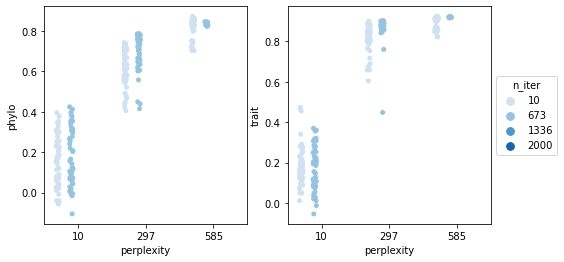

In [377]:
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(1,2,1)
sns.stripplot(data=tsne_opt.reset_index(), 
              x='perplexity', 
              hue='iterations', 
              y='phylo', dodge=True, palette='Blues')
ax.get_legend().remove()
ax = fig.add_subplot(1,2,2)
sns.stripplot(data=tsne_opt.reset_index(), 
              x='perplexity', 
              hue='iterations', 
              y='trait', 
              dodge=True, palette='Blues')
lgd = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='n_iter')

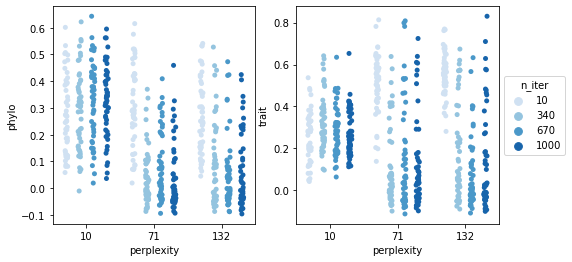

In [293]:
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(1,2,1)
sns.stripplot(data=tsne_opt.reset_index(), 
              x='perplexity', 
              hue='iterations', 
              y='phylo', dodge=True, palette='Blues')
ax.get_legend().remove()
ax = fig.add_subplot(1,2,2)
sns.stripplot(data=tsne_opt.reset_index(), 
              x='perplexity', 
              hue='iterations', 
              y='trait', 
              dodge=True, palette='Blues')
lgd = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='n_iter')

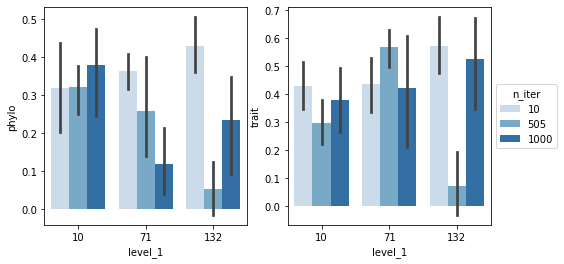

In [280]:
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(1,2,1)
sns.barplot(data=tsne_opt.reset_index(), x='level_1', hue='level_0', y='phylo', palette='Blues')
ax.get_legend().remove()
ax = fig.add_subplot(1,2,2)
sns.barplot(data=tsne_opt.reset_index(), x='level_1', hue='level_0', y='trait', palette='Blues')
lgd = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='n_iter')

(585, 585)
(585, 11)
len 1
len 1


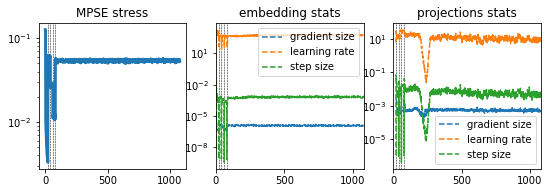

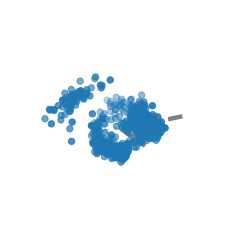

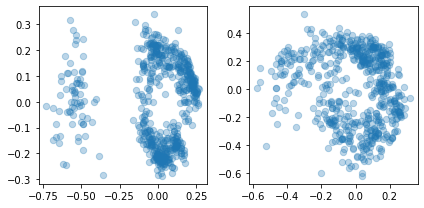

In [378]:
# perform t-SNE
phylum_tsne = mview.mpse_tsne(data=[phylum_dist_matrix, phylum_pca_data.values],
                 perplexity=585,
                 iters=1000,
                 smart_init=True,
                 verbose=0,
                 show_plots=True)

In [379]:
def plot2d(y1,y2,C,title=None):
    #Plot results
    fig, (ax1,ax2) = plt.subplots(1,2)
    # y1 = mv.images[0,:,:]
    # y2 = mv.images[1,:,:]
    for ax,emb in zip([ax1,ax2],[y1,y2]):
        x , y = emb[:,0], emb[:,1]
        ax.scatter(x,y,c=C)
        # for i in range(len(labels)):
        #     x,y = emb[i,0], emb[i,1]
        #     txt = ax.annotate(labels[i],(x,y),textcoords="offset points",
        #                 xytext=(0,4),ha='center',fontsize='large',weight="bold",
        #                 horizontalalignment='center',color='black')
        #     txt.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='w')])
        ax.set_xticks([])
        ax.set_yticks([])

    fig.set_size_inches(8,4)

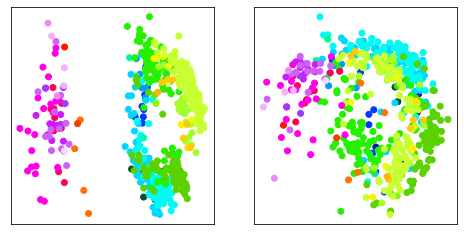

In [380]:
y1 = phylum_tsne.images[0, :, :]
y2 = phylum_tsne.images[1, :, :]
unique_taxa = md_top_phyla.set_index('accession_reformat').reindex(phylum_keep_rows_names)['Family'].unique()
taxa2color = dict((t, to_hex(c)) for t, c in zip(unique_taxa, sns.color_palette('gist_ncar', n_colors=len(unique_taxa))))
hues =[ taxa2color[t] for t in md_top_phyla.set_index('accession_reformat').reindex(phylum_keep_rows_names)['Family'].values]
plot2d(y1, y2, hues)

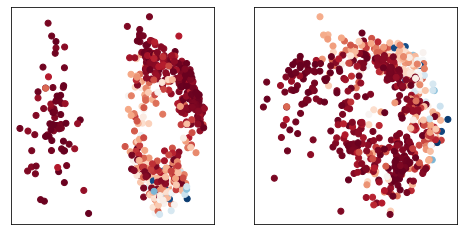

In [381]:
y1 = phylum_tsne.images[0, :, :]
y2 = phylum_tsne.images[1, :, :]
# unique_taxa = phylum_pca_data.loc[phylum_keep_rows_names)['Class'].unique()
pal = cm.get_cmap('RdBu')
hues =[ pal(phylum_pca_data.loc[t, 'aerobe']) for t in phylum_keep_rows_names]
plot2d(y1, y2, hues)

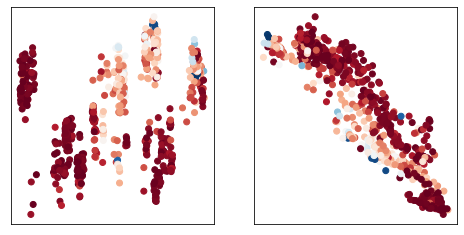

In [373]:
y1 = phylum_tsne.images[0, :, :]
y2 = phylum_tsne.images[1, :, :]
# unique_taxa = phylum_pca_data.loc[phylum_keep_rows_names)['Class'].unique()
pal = cm.get_cmap('RdBu')
hues =[ pal(phylum_pca_data.loc[t, 'aerobe']) for t in phylum_keep_rows_names]
plot2d(y1, y2, hues)

### Metric to describe whether t-SNE is doing a good job collapsing the information

In [70]:
test_point = 'GB_GCA_017498545_1'

### Mantel test on traits

In [73]:
# dims = ['dim2', 'dim3']
# a = phylum_plot_data.loc[test_point, dims].values
ap = image1_phylo_df.loc[test_point, :].values
at = image2_trait_df.loc[test_point, :].values

sample_set = phylum_plot_data[~phylum_plot_data.index.str.contains(test_point)].sample(100).index

phylo_tsne_dists = pd.Series(index=sample_set, data=[np.linalg.norm(ap-image1_phylo_df.loc[b, :].values) for b in sample_set])
trait_tsne_dists = pd.Series(index=sample_set, data=[np.linalg.norm(at-image2_trait_df.loc[b, :].values) for b in sample_set])

In [74]:
ids = list(sample_set) + [test_point]
# vector of T/F for leaves in the trait data used to subset distance matrix
test_keep_rows = np.array([r in ids for r in row_names])

# same as above, used to reindex trait data
test_keep_rows_names = np.array([r for r in row_names if r in ids])

# # get distance matrix
test_dist_matrix = pd.DataFrame(columns=test_keep_rows_names,
                                index=test_keep_rows_names,
                                data=distance_matrix[test_keep_rows, :][:, test_keep_rows])



Text(0, 0.5, 'tsne_distance')

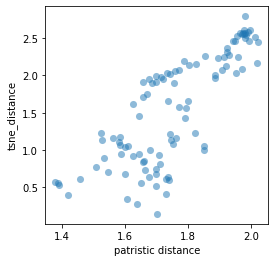

In [75]:
fig, ax = plt.subplots(figsize=(4,4))
sns.scatterplot(x=test_dist_matrix.loc[test_point, sample_set], y=phylo_tsne_dists, s=50, alpha=0.5, linewidth=0)
ax.set_xlabel('patristic distance')
ax.set_ylabel('tsne_distance')

In [776]:
a = phylum_pca_data.loc[test_point, :].values
data_dists = pd.Series(index=sample_set, data=[np.linalg.norm(a-b) for b in phylum_pca_data.values])

Text(0.5, 0, 'data dists')

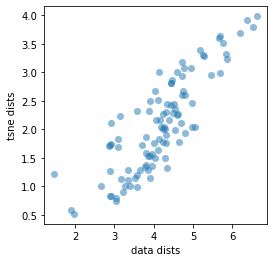

In [777]:
fig, ax = plt.subplots(figsize=(4,4))
sns.scatterplot(x=data_dists, y=trait_tsne_dists, s=50, alpha=0.5, linewidth=0)
ax.set_ylabel('tsne dists')
ax.set_xlabel('data dists')

In [39]:
phylum_tsne.projections.shape

(2, 2, 3)

In [40]:
phylum_tsne_embedding = pd.DataFrame(index=phylum_keep_rows_names, data=phylum_tsne.embedding, columns=['dim1', 'dim2', 'dim3'])
phylum_tsne_embedding

phylum_plot_data = phylum_tsne_embedding.sort_values('dim1')


In [41]:
phylum_color_list = ['red', 'green', 'blue', 'gold', 'greenyellow', 'darkviolet', 'lightgray',
                     'darkred', 'brown', 'darkorange', 'chocolate', 'crimson', 'fuchsia', 'tomato',  'lightgreen', 'salmon',
                     'olive', 'mediumpurple',   'pink', 'violet', 'yellow', 
                     'darkslategrey', 'darkblue', 'dodgerblue',   'mediumturquoise', 'thistle', 'darkseagreen',
                       'y',  'paleturquoise', 'g', 'cyan', 'grey', ]

phylum_color_dict = dict(zip(md_top_phyla.set_index('accession_reformat').reindex(pca_data.index)['Phylum'].fillna('Small phylum').value_counts().index,
             phylum_color_list))

In [42]:
hues = md_top_phyla.set_index('accession_reformat').reindex(phylum_keep_rows_names)['Phylum'].values
hues = [p if p in phylum_color_dict.keys() else 'Small phylum' for p in hues]

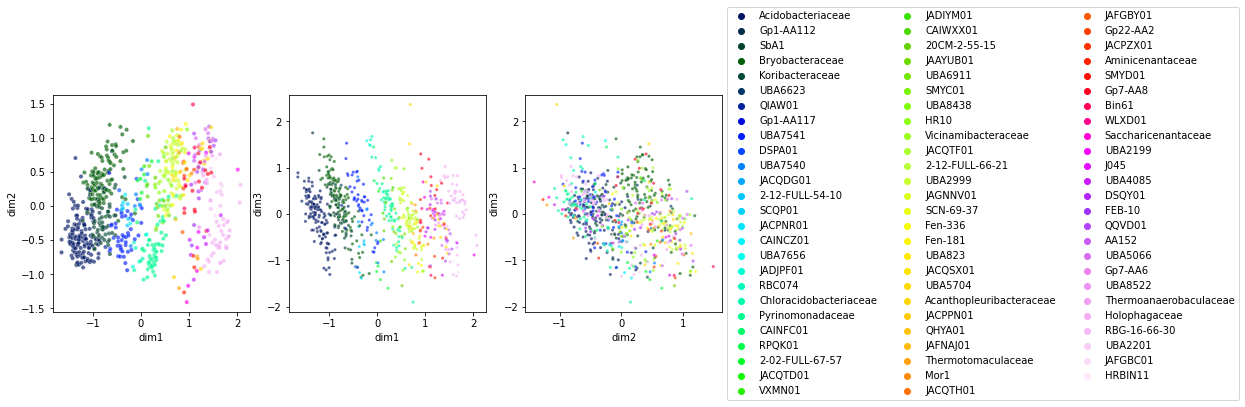

In [43]:
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1,3,1)

size=10
alpha=0.65
# selected = ['Proteobacteria', 'Firmicutes', 'Firmicutes_A', 'Bacteroidota', 'Chlamydiota', 'Actinobacteriota']
# hues = [h if h in selected else 'other' for h in hues ]
hues = md_top_phyla.set_index('accession_reformat').reindex(phylum_plot_data.index)['Family'].values
sns.scatterplot(data=phylum_plot_data, x='dim1', y='dim2', size=size, alpha=alpha, hue=hues, palette='gist_ncar')
ax.get_legend().remove()

ax = fig.add_subplot(1,3,2)
sns.scatterplot(data=phylum_plot_data, x='dim1', y='dim3', s=size, alpha=alpha, hue=hues, palette='gist_ncar')
# lgd = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), facecolor='white')
ax.get_legend().remove()

ax = fig.add_subplot(1,3,3)
sns.scatterplot(data=phylum_plot_data, x='dim2', y='dim3', s=size, alpha=alpha, hue=hues, palette='gist_ncar')
lgd = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), facecolor='white', ncol=3)
# plt.savefig('/data/mhoffert/fiererlab/periodic_phyla/results/20230816_enstsne_perp1000_iter2000.png', dpi=400, bbox_inches='tight')

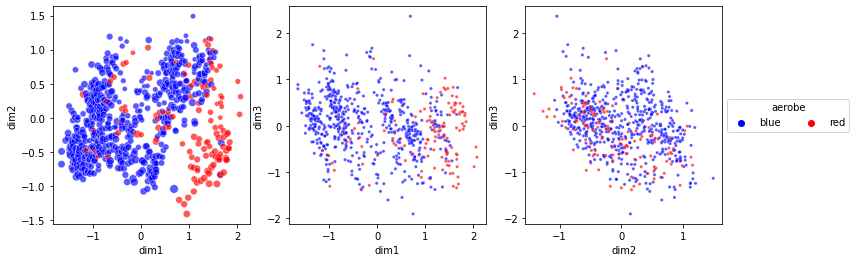

In [44]:
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1,3,1)

size=10
alpha=0.65
# selected = ['Proteobacteria', 'Firmicutes', 'Firmicutes_A', 'Bacteroidota', 'Chlamydiota', 'Actinobacteriota']
var = 'aerobe'
cutoff = 0.5
hues = ['blue' if pca_data.loc[t, var] > cutoff else 'red' for t in phylum_plot_data.index]
sns.scatterplot(data=phylum_plot_data, x='dim1', y='dim2', size=phylum_plot_data['dim3'], alpha=alpha, hue=hues, 
                hue_order=['blue', 'red'], 
                palette=['b', 'r'])
ax.get_legend().remove()

ax = fig.add_subplot(1,3,2)
sns.scatterplot(data=phylum_plot_data, x='dim1', y='dim3', s=size, alpha=alpha, hue=hues, 
                hue_order=['blue', 'red'], 
                palette=['b', 'r'])
# lgd = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), facecolor='white')
ax.get_legend().remove()

ax = fig.add_subplot(1,3,3)
sns.scatterplot(data=phylum_plot_data, x='dim2', y='dim3', s=size, alpha=alpha, hue=hues, 
                hue_order=['blue', 'red'], 
                palette=['b', 'r'])
lgd = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), facecolor='white', ncol=3, title=var)
# plt.savefig('/data/mhoffert/fiererlab/periodic_phyla/results/20230816_enstsne_perp1000_iter2000.png', dpi=400, bbox_inches='tight')

In [45]:
y = [1 if pca_data.loc[t, 'aerobe'] > 0.5 else -1 for t in phylum_plot_data.index]
X = phylum_plot_data.values

In [46]:
clf = svm.SVC(kernel="linear", C=100)
clf.fit(X, y)

SVC(C=100, kernel='linear')

In [47]:
(clf.predict(X) == y).sum() / len(y)

0.9140845070422535

In [48]:
def make_meshgrid(clf, x, y, z, h=.2, **params):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    z_min, z_max = z.min() - 1, z.max() + 1 
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), 
                         np.arange(y_min, y_max, h))
    
    
    Zs = np.array([0]*(xx.shape[0]*xx.shape[1])).reshape(xx.shape)
    for z_i in np.arange(z_min - 1, z_max + 1, 0.5):
        fake_zs = np.array([z_i]*(xx.shape[0]*xx.shape[1])).reshape(xx.shape)        
        # make sure input dimensions are always aligned
        placement_dict = {x.name:xx, y.name:yy, z.name:fake_zs}
        Z = clf.predict(np.c_[placement_dict['dim1'].ravel(), placement_dict['dim2'].ravel(), placement_dict['dim3'].ravel()])
        Z = Z.reshape(xx.shape)
        Zs = Zs + Z
    return xx, yy, Zs

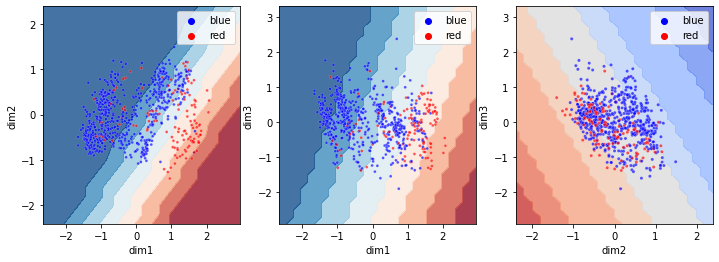

In [49]:
fig = plt.figure(figsize=(12,4))
hues = ['blue' if pca_data.loc[t, 'aerobe'] > 0.5 else 'red' for t in phylum_plot_data.index]

ax = fig.add_subplot(1,3,1)
# the inputs need to be aligned with the predictor function
xx, yy, Zs = make_meshgrid(clf, phylum_plot_data['dim1'],
                           phylum_plot_data['dim2'],
                           phylum_plot_data['dim3'])

ax.contourf(xx, yy, Zs, cmap=plt.cm.RdBu, alpha=0.8)

sns.scatterplot(data=phylum_plot_data, x='dim1', y='dim2', s=8, alpha=alpha, hue=hues, 
                hue_order=['blue', 'red'],
                palette=['b', 'r'])

ax = fig.add_subplot(1,3,2)

xx, yy, Zs = make_meshgrid(clf, phylum_plot_data['dim1'],
                           phylum_plot_data['dim3'],
                           phylum_plot_data['dim2'])

ax.contourf(xx, yy, Zs, cmap=plt.cm.RdBu, alpha=0.8)

sns.scatterplot(data=phylum_plot_data, x='dim1', y='dim3', s=8, alpha=alpha, hue=hues, 
                hue_order=['blue', 'red'],
                palette=['b', 'r'])


ax = fig.add_subplot(1,3,3)
# the inputs need to be aligned with the predictor function
# the inputs need to be aligned with the predictor function

# the inputs need to be aligned with the predictor function
xx, yy, Zs = make_meshgrid(clf, phylum_plot_data['dim2'],
                           phylum_plot_data['dim3'],
                           phylum_plot_data['dim1'])

ax.contourf(xx, yy, Zs, cmap=plt.cm.coolwarm_r, alpha=0.8)

sns.scatterplot(data=phylum_plot_data, x='dim2', y='dim3', s=size, alpha=alpha, hue=hues, 
                hue_order=['blue', 'red'],
                palette=['b', 'r'])


plt.show()

In [50]:
palette = cm.get_cmap('RdBu')
unique_genera = md_top_phyla.set_index('accession_reformat')
colormap = [sns.color_palette('gist_ncar')]
# TreeStyle for collapsed tree
# central = row_names[6000]
def layout_collapsed(node):
    # print(node.name)
                

    internal_ns = NodeStyle()
    internal_ns['size'] = 0
    
    if node.is_leaf():
        internal_ns['size'] = 2
        internal_ns['fgcolor'] = 'k'
        if node.name in phylum_pca_data.index:
            if phylum_pca_data.loc[node.name, 'aerobe'] > 0.5:
                internal_ns['fgcolor'] = 'blue'
            else:
                internal_ns['fgcolor'] = 'red'

        
    node.img_style = internal_ns
        

ts = TreeStyle()
ts.mode = 'c'
ts.layout_fn = layout_collapsed
# ts.scale=200
ts.show_leaf_name = False
ts.draw_guiding_lines = False

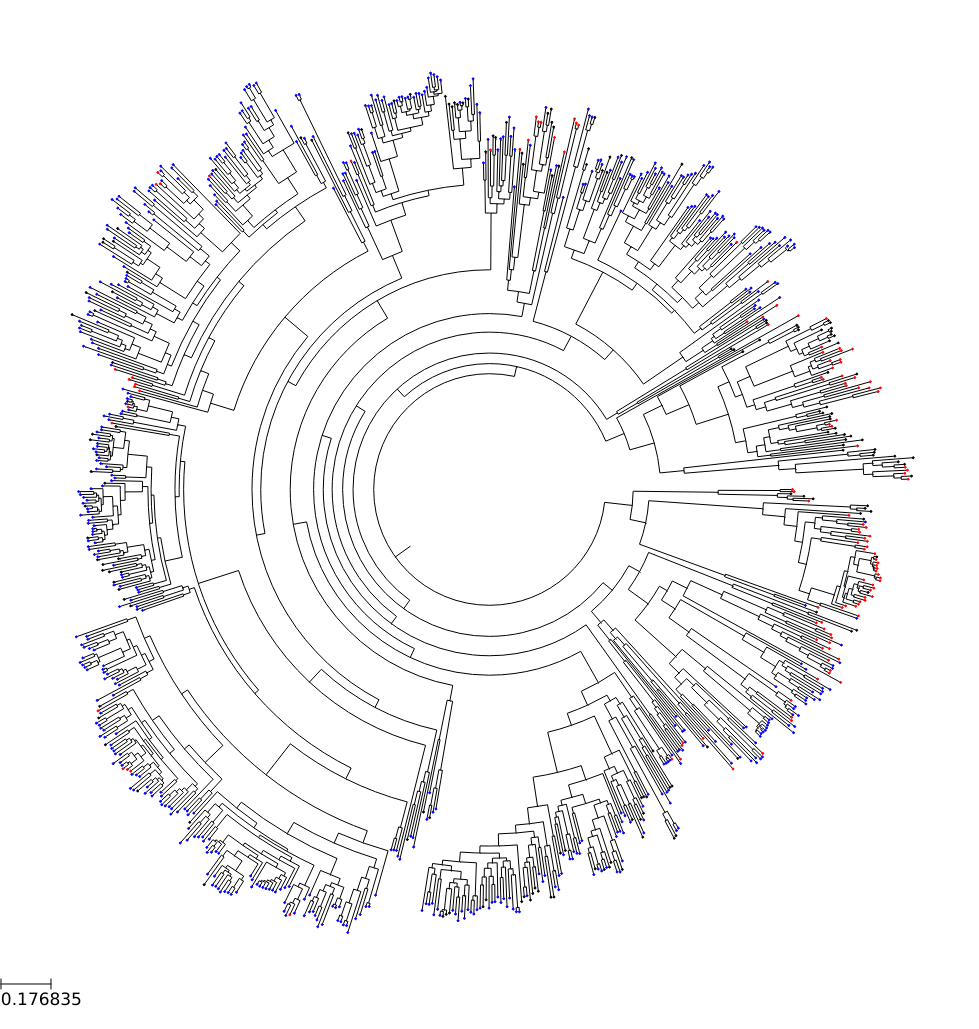

In [51]:
test_clade.render('%%inline', tree_style=ts)

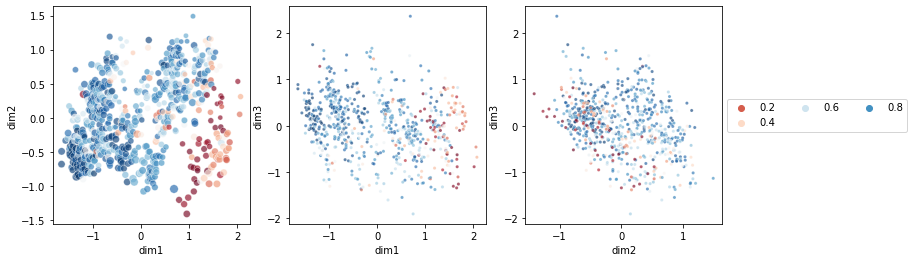

In [52]:
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1,3,1)

size=10
alpha=0.65
# selected = ['Proteobacteria', 'Firmicutes', 'Firmicutes_A', 'Bacteroidota', 'Chlamydiota', 'Actinobacteriota']
hues = [pca_data.loc[t, 'aerobe'] for t in phylum_plot_data.index]
palette = 'RdBu' #['red', 'blue']
sns.scatterplot(data=phylum_plot_data, x='dim1', y='dim2', size=phylum_plot_data['dim3'], alpha=alpha, hue=hues, palette=palette)
ax.get_legend().remove()

ax = fig.add_subplot(1,3,2)
sns.scatterplot(data=phylum_plot_data, x='dim1', y='dim3', s=size, alpha=alpha, hue=hues, palette=palette)
# lgd = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), facecolor='white')
ax.get_legend().remove()

ax = fig.add_subplot(1,3,3)
sns.scatterplot(data=phylum_plot_data, x='dim2', y='dim3', s=size, alpha=alpha, hue=hues, palette=palette)
lgd = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), facecolor='white', ncol=3)

## Attempting SVM segmentation-based collapsing

In [53]:
def collapseTree(tree, tsne_acc_thresh, tsne_data, n_leaves): # add to ete utils
    #is there a better way to collapse that preserves properties?
    t = Tree(tree.write(is_leaf_fn=lambda n: collapseClades(tsne_data, n, tsne_acc_thresh, n_leaves), format=3),format=3) 
    t.name = tree.name
    return t

def collapseClades(tsne_dims, node, accuracy, leaf_count):
    '''collapses clades below max_leaf_dist. can be passed as is_leaf_fn'''
    if node.is_leaf():
        return True
    else:
        # fit tsne
        clf = svm.SVC(kernel="poly", C=100)
        node_leaves = [l.name for l in node.get_leaves()]
        if len(node_leaves) ==  leaf_count:
            return False
        else:
            y = [i in node_leaves for i in tsne_dims.index]
            clf.fit(tsne_dims.values, y)
            # get accuracy
            tsne_acc = (clf.predict(X) == y).sum() / len(y)

            return tsne_acc < accuracy

In [54]:
len(test_clade.get_leaves())

873

In [55]:
len(phylum_plot_data)

710

In [56]:
pruned_test_clade = test_clade.copy()
pruned_test_clade.prune(nodes=phylum_plot_data.index)

In [57]:
pruned_test_clade.describe()

Number of leaf nodes:	710
Total number of nodes:	1419
Rooted:	Yes
Most distant node:	RS_GCF_010093025_1
Max. distance:	1.273290


In [58]:
collapsed = collapseTree(pruned_test_clade, 0.99, phylum_plot_data, len(pruned_test_clade.get_leaves()))

In [59]:
collapsed.describe()

Number of leaf nodes:	20
Total number of nodes:	39
Rooted:	Yes
Most distant node:	GB_GCA_002747255_1
Max. distance:	0.821460


In [60]:
"""Map OTUs to clades (leaves of collapsed trees)"""
# Get leafs of collapsed tree
collapsed_leafs = collapsed.get_leaf_names()
# collapsed_leafs = drawn_tree.get_leaf_names()

collapsed_clades = [c for c in collapsed_leafs if c.startswith('c')]
# Map OTUs to clades
otu2clade = {}
for leaf in collapsed_leafs:
    if leaf.startswith('c'):
        # Search for leaves of `collapsed` as nodes in `pruned`, then get all OTUs under that node
        for otu in pruned_test_clade.search_nodes(name=leaf)[0].get_leaf_names():
            otu2clade[otu] = leaf
    else:
        otu2clade[leaf] = leaf

otu_taxa = pd.DataFrame([{'feature': o, 'clade': c} for o, c in otu2clade.items()])


clade_map = otu_taxa.groupby('clade').apply(lambda x: list(x['feature'].astype(str)))

In [61]:
clade_map

clade
GB_GCA_002747255_1                                 [GB_GCA_002747255_1]
GB_GCA_012103255_1                                 [GB_GCA_012103255_1]
GB_GCA_013151025_1                                 [GB_GCA_013151025_1]
GB_GCA_015487755_1                                 [GB_GCA_015487755_1]
GB_GCA_016191015_1                                 [GB_GCA_016191015_1]
GB_GCA_016213735_1                                 [GB_GCA_016213735_1]
GB_GCA_016710635_1                                 [GB_GCA_016710635_1]
GB_GCA_016720465_1                                 [GB_GCA_016720465_1]
GB_GCA_016722505_1                                 [GB_GCA_016722505_1]
GB_GCA_016932915_1                                 [GB_GCA_016932915_1]
GB_GCA_017498545_1                                 [GB_GCA_017498545_1]
GB_GCA_903916735_1                                 [GB_GCA_903916735_1]
RS_GCF_016592575_1                                 [RS_GCF_016592575_1]
c001712               [GB_GCA_002898535_1, GB_GCA_00231631

In [62]:
palette = cm.get_cmap('RdBu')
unique_genera = md_top_phyla.set_index('accession_reformat')
# colormap = [sns.color_palette('gist_ncar')]
# TreeStyle for collapsed tree
# central = row_names[6000]
def layout_collapsed(node):
    # print(node.name)
                

    internal_ns = NodeStyle()
    internal_ns['size'] = 0
    internal_ns['fgcolor'] = 'k'
    
    if node.is_leaf():
        internal_ns['size'] = 2
        if len(clade_map.loc[node.name]) == 1:
            internal_ns['fgcolor'] = 'red'
        # if node.name in phylum_pca_data.index:
            if phylum_pca_data.loc[node.name, 'aerobe'] > 0.5:
                internal_ns['fgcolor'] = 'blue'
            else:
                internal_ns['fgcolor'] = 'red'
        else:
            internal_ns['fgcolor'] = to_hex(palette(pca_data.loc[clade_map.loc[node.name], 'aerobe'].mean()))
            internal_ns['size'] = len(clade_map.loc[node.name]) / 10


        
    node.img_style = internal_ns
        

ts = TreeStyle()
ts.mode = 'c'
ts.layout_fn = layout_collapsed
ts.scale=200
ts.show_leaf_name = False
ts.draw_guiding_lines = False

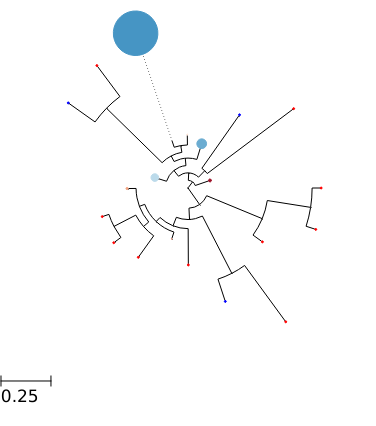

In [63]:
collapsed.render('%%inline', tree_style=ts)

In [64]:
clade_cmap = dict((c, to_hex(col)) for c, col in zip(clade_map.index, sns.color_palette('tab10', n_colors=len(clade_map))))

In [65]:
def layout_collapsed(node):

    internal_ns = NodeStyle()
    internal_ns['size'] = 0
    
    # if node.is_leaf():
    internal_ns['fgcolor'] = 'k'
#         if len(clade_map.loc[node.name]) == 1:
        
#         # if node.name in phylum_pca_data.index:
#             if phylum_pca_data.loc[node.name, 'aerobe'] > 0.5:
#                 internal_ns['fgcolor'] = 'blue'
#             else:
    if node.is_leaf():
        try:
            internal_ns['fgcolor'] = clade_cmap[otu2clade[node.name]]
        except KeyError:
            print(node.name)
            internal_ns['fgcolor'] = 'k'
            internal_ns['size'] = 5


    # internal_ns['fgcolor'] = to_hex(palette(pca_data.loc[clade_map.loc[node.name], 'aerobe'].mean()))
    if node.name in clade_map.index:
        internal_ns['size'] = max([len(clade_map.loc[node.name]) / 5, 2])
        
    node.img_style = internal_ns
        

ts = TreeStyle()
ts.mode = 'c'
ts.layout_fn = layout_collapsed
ts.scale=200
ts.show_leaf_name = False
ts.draw_guiding_lines = False

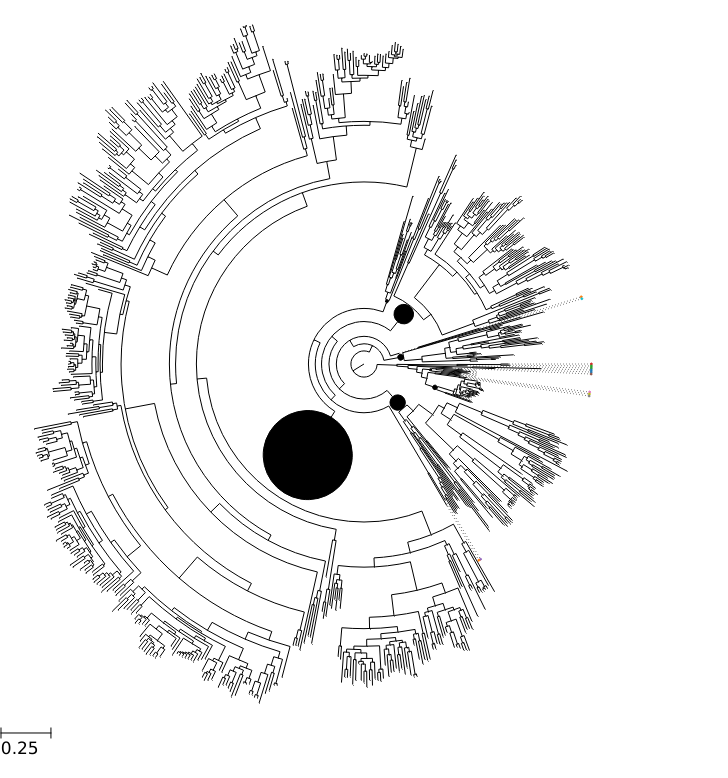

In [66]:
pruned_test_clade.render('%%inline', tree_style=ts)

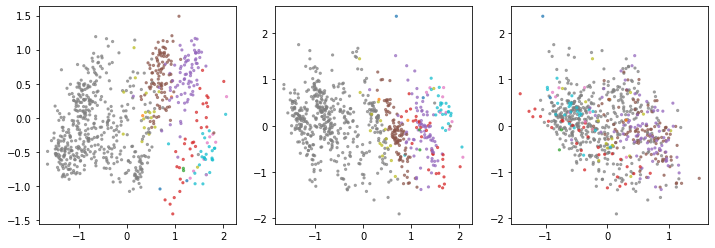

In [67]:
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1,3,1)

size=10
alpha=0.65
# selected = ['Proteobacteria', 'Firmicutes', 'Firmicutes_A', 'Bacteroidota', 'Chlamydiota', 'Actinobacteriota']
hues = [clade_cmap[otu2clade[t]] for t in phylum_plot_data.index]
palette = 'brg' #['red', 'blue']
ax.scatter(x=phylum_plot_data['dim1'], 
           y=phylum_plot_data['dim2'], s=5, alpha=alpha, c=hues)
# ax.get_legend().remove()

ax = fig.add_subplot(1,3,2)
ax.scatter(x=phylum_plot_data['dim1'], 
           y=phylum_plot_data['dim3'], s=5, alpha=alpha, c=hues)
# lgd = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), facecolor='white')
# ax.get_legend().remove()

ax = fig.add_subplot(1,3,3)
ax.scatter(x=phylum_plot_data['dim2'], 
           y=phylum_plot_data['dim3'], s=5, alpha=alpha, c=hues)
# lgd = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), facecolor='white', ncol=3)

In [68]:
cm = plt.cm.gnuplot
def layout_collapsed(node):

    internal_ns = NodeStyle()
    internal_ns['size'] = 2
    if node.name[0] == 'c':
        # print(names_map.loc[node.name])
        internal_ns['fgcolor'] = to_hex(cm(float(names_map.loc[node.name].split(':')[0]) / 100))
        
    if node.is_leaf():
        try:
            internal_ns['fgcolor'] = clade_cmap[otu2clade[node.name]]
        except KeyError:
            print(node.name)
            internal_ns['fgcolor'] = 'k'
            internal_ns['size'] = 5

    node.img_style = internal_ns
        

ts = TreeStyle()
ts.mode = 'c'
ts.layout_fn = layout_collapsed
ts.scale=200
ts.show_leaf_name = False
ts.draw_guiding_lines = False

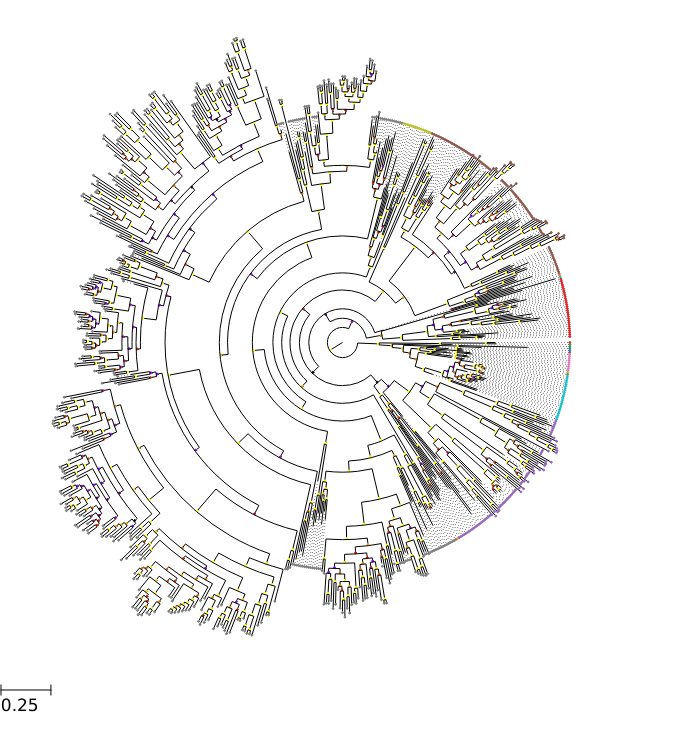

In [69]:
pruned_test_clade.render('%%inline', tree_style=ts)

In [693]:
test_dist_matrix.loc[test_point, sample_set.index].sort_values()

GB_GCA_017498545_1    0.00000
GB_GCA_017859955_1    1.37197
GB_GCA_003223995_1    1.40273
GB_GCA_903913215_1    1.43568
GB_GCA_903843705_1    1.44322
                       ...   
RS_GCF_900108185_1    2.02599
GB_GCA_003142235_1    2.02661
GB_GCA_016871155_1    2.03511
GB_GCA_016871055_1    2.03541
GB_GCA_000421065_1    2.07301
Name: GB_GCA_017498545_1, Length: 100, dtype: float32

In [683]:
test_dist_matrix.loc[test_point, :]

GB_GCA_015487755_1    1.23890
RS_GCF_016592575_1    1.24474
GB_GCA_013151025_1    1.29729
GB_GCA_016213735_1    1.32872
GB_GCA_003165415_1    1.38852
                       ...   
GB_GCA_018894615_1    1.67556
GB_GCA_004525465_1    1.83703
GB_GCA_016934475_1    1.84423
GB_GCA_002335385_1    1.83427
GB_GCA_002436105_1    1.84572
Name: GB_GCA_017498545_1, Length: 700, dtype: float32

In [662]:
test_dist_matrix.loc[test_point, :]

GB_GCA_016213735_1    1.32872
GB_GCA_002297665_1    1.39294
GB_GCA_903880675_1    1.46178
GB_GCA_003158505_1    1.44768
GB_GCA_903919165_1    1.46015
                       ...   
GB_GCA_003170135_1    1.52054
GB_GCA_017999365_1    1.69978
GB_GCA_017883305_1    1.70233
GB_GCA_001775755_1    1.65280
GB_GCA_002335385_1    1.83427
Name: GB_GCA_017498545_1, Length: 100, dtype: float32

In [664]:
tsne_dists

GB_GCA_011389255_1    3.892098
GB_GCA_002197525_1    3.583634
RS_GCF_004217555_1    2.803669
GB_GCA_015655585_1    3.004911
GB_GCA_013152925_1    2.205840
                        ...   
GB_GCA_013203475_1    1.914279
GB_GCA_900696665_1    2.514420
GB_GCA_016933515_1    3.803234
GB_GCA_016178075_1    3.580359
GB_GCA_016185465_1    3.423702
Length: 100, dtype: float64

In [ ]:
test

In [645]:
patristic_distance_matrix

array([[0.     , 1.76164, 1.65819, ..., 2.65738, 2.61193, 2.41269],
       [1.76164, 0.     , 0.65537, ..., 2.52988, 2.48443, 2.28519],
       [1.65819, 0.65537, 0.     , ..., 2.42643, 2.38098, 2.18174],
       ...,
       [2.65738, 2.52988, 2.42643, ..., 0.     , 0.53837, 1.64623],
       [2.61193, 2.48443, 2.38098, ..., 0.53837, 0.     , 1.60078],
       [2.41269, 2.28519, 2.18174, ..., 1.64623, 1.60078, 0.     ]],
      dtype=float32)

In [641]:
phylum_plot_data.sample(100).values

array([[-2.18813206e-01,  4.59696947e-02, -7.10157566e-01],
       [ 6.03700164e-01,  1.71176500e+00,  5.09853337e-02],
       [ 3.69486919e-01, -3.02594120e-01,  7.98575863e-01],
       [-1.93161522e-01, -9.15882701e-01,  2.15497136e-02],
       [ 4.29842852e-01, -1.17594884e+00, -3.74571059e-01],
       [-6.19574283e-01, -5.59672811e-01,  9.96170674e-01],
       [ 8.32151747e-01,  1.06932627e+00, -7.31372617e-02],
       [ 8.90315969e-01,  1.32101922e+00, -1.08726061e+00],
       [-2.21301608e-01,  4.97127101e-04, -7.38227645e-01],
       [-1.48482726e-01, -1.54560226e+00,  1.54817213e-03],
       [ 3.35172400e-01,  1.62809719e+00, -1.67015861e-01],
       [ 1.22386469e-02, -8.02985145e-01,  1.66842659e-01],
       [ 2.60233900e-01,  1.01504937e+00, -2.10093096e-01],
       [-2.61852237e-01, -4.84704762e-01, -3.21358520e-01],
       [-2.45984593e-01, -5.90347697e-01,  5.59027818e-01],
       [-7.89591712e-01, -1.64918502e+00,  1.96080696e-01],
       [ 2.39142902e-01, -2.39244372e-01

In [ ]:
numpy.linalg.norm(a-b)

In [631]:
phylum_pca_data

aerobe  phototroph  3HP bicycle  3HP/4HB  Calvin Cycle  \
GB_GCA_015487755_1  0.032046         0.0          0.0      0.0           0.0   
RS_GCF_016592575_1  0.004776         0.0          0.0      0.0           0.0   
GB_GCA_013151025_1  0.082553         0.0          0.0      0.0           0.0   
GB_GCA_016213735_1  0.282881         0.0          0.0      0.0           0.0   
GB_GCA_003165415_1  0.609387         0.0          0.0      0.0           0.0   
...                      ...         ...          ...      ...           ...   
GB_GCA_018894615_1  0.029109         0.0          0.0      0.0           0.0   
GB_GCA_004525465_1  0.062319         0.0          0.0      0.0           0.0   
GB_GCA_016934475_1  0.061684         0.0          0.0      0.0           0.0   
GB_GCA_002335385_1  0.078831         0.0          0.0      0.0           0.0   
GB_GCA_002436105_1  0.045491         0.0          0.0      0.0           0.0   

                    rAcoA homoacetogenic  rTCA I  rTCA II  growth_rate  \
GB_GCA_015487755_1                   0.0     0.0      0.0    -0.403240   
RS_GCF_016592575_1                   0.0     0.0      0.0     0.654144   
GB_GCA_013151025_1                   0.0     0.0      0.0     0.401873   
GB_GCA_016213735_1                   0.0     0.0      0.0     0.950221   
GB_GCA_003165415_1                   0.0     0.0      0.0     0.357458   
...                                  ...     ...      ...          ...   
GB_GCA_018894615_1                   0.0     0.0      0.0     0.275319   
GB_GCA_004525465_1                   0.0     0.0      0.0    -0.484479   
GB_GCA_016934475_1                   0.0     0.0      0.0     3.444562   
GB_GCA_002335385_1                   0.0     0.0      0.0     0.633416   
GB_GCA_002436105_1                   0.0     0.0      0.0     0.222931   

                    genome_size  gc_percentage  
GB_GCA_015487755_1    -0.999845      -1.115150  
RS_GCF_016592575_1    -0.659765      -1.346589  
GB_GCA_013151025_1    -0.494001      -0.264490  
GB_GCA_016213735_1     0.004590       1.255739  
GB_GCA_003165415_1     0.656243       1.142770  
...                         ...            ...  
GB_GCA_018894615_1    -0.328167       0.074428  
GB_GCA_004525465_1    -0.435974       0.150781  
GB_GCA_016934475_1    -0.527482       0.889288  
GB_GCA_002335385_1    -0.328177       0.814592  
GB_GCA_002436105_1    -0.242891       0.798893  

[710 rows x 11 columns]

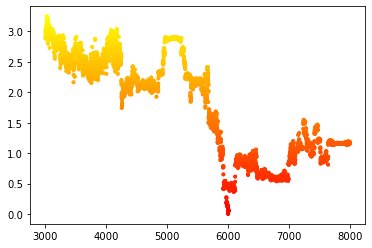

In [116]:
bottom, top = 3000, 8000
plt.scatter(y=distance_matrix[6000, bottom:top], x=range(bottom,top), s=10, c=distance_matrix[6000, bottom:top], cmap='autumn')

In [118]:
pca_data

aerobe  phototroph  3HP bicycle  3HP/4HB  Calvin Cycle  \
GB_GCA_000007325_1  0.001817           0          0.0      0.0           0.0   
GB_GCA_000008885_1  0.470498           0          0.0      0.0           0.0   
GB_GCA_000009845_1  0.682832           0          0.0      0.0           0.0   
GB_GCA_000010085_1  0.865893           0          0.0      0.0           0.0   
GB_GCA_000010565_1  0.018416           0          0.0      0.0           0.0   
...                      ...         ...          ...      ...           ...   
RS_GCF_907165215_1  0.987057           0          0.0      0.0           0.0   
RS_GCF_910593725_1  0.275134           0          0.0      0.0           0.0   
RS_GCF_910593785_1  0.946832           0          0.0      0.0           0.0   
RS_GCF_910593845_1  0.971290           0          0.0      0.0           0.0   
RS_GCF_910594985_1  0.956487           0          0.0      0.0           0.0   

                    rAcoA homoacetogenic  rTCA I  rTCA II  growth_rate  \
GB_GCA_000007325_1                   0.0     0.0      0.0     9.686217   
GB_GCA_000008885_1                   0.0     0.0      0.0    10.395816   
GB_GCA_000009845_1                   0.0     0.0      0.0    11.625192   
GB_GCA_000010085_1                   0.0     0.0      0.0     1.253937   
GB_GCA_000010565_1                   0.0     0.0      0.0     4.432701   
...                                  ...     ...      ...          ...   
RS_GCF_907165215_1                   0.0     0.0      0.0     4.458259   
RS_GCF_910593725_1                   0.0     0.0      0.0     6.484906   
RS_GCF_910593785_1                   0.0     0.0      0.0     5.998208   
RS_GCF_910593845_1                   0.0     0.0      0.0     0.476456   
RS_GCF_910594985_1                   0.0     0.0      0.0     1.099750   

                    genome_size  gc_percentage  
GB_GCA_000007325_1      2174500      27.151588  
GB_GCA_000008885_1       703004      22.475121  
GB_GCA_000009845_1       853092      27.759941  
GB_GCA_000010085_1      4292502      54.504948  
GB_GCA_000010565_1      3025375      52.961104  
...                         ...            ...  
RS_GCF_907165215_1      4109925      61.042313  
RS_GCF_910593725_1      1196295      42.463356  
RS_GCF_910593785_1      2865069      69.471967  
RS_GCF_910593845_1      7609664      53.979439  
RS_GCF_910594985_1      8178005      51.194005  

[51880 rows x 11 columns]

ValueError: x and y must be the same size

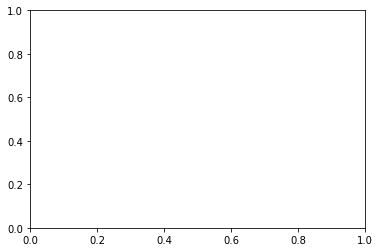

In [117]:
plt.scatter(y=pca_data.iloc[6000, bottom:top], x=range(bottom,top), s=10, c=distance_matrix[6000, bottom:top], cmap='autumn')

In [85]:
test_tree = gtdb_full.copy()

In [86]:
test_tree.prune(row_names[5920:6100])

In [87]:
test_tree.describe()

Number of leaf nodes:	180
Total number of nodes:	359
Rooted:	Yes
Most distant node:	RS_GCF_006569205_1
Max. distance:	0.479180


In [88]:
from matplotlib.colors import to_hex

In [100]:
palette = cm.get_cmap('autumn')
# TreeStyle for collapsed tree
central = row_names[6000]
def layout_collapsed(node):
    # print(node.name)
                

    internal_ns = NodeStyle()
    internal_ns['size'] = 0

    # if len(node.get_leaves()) < 1000:
    #     internal_ns['size'] = 2
    #     internal_ns['fgcolor'] = 'red'
    
    if node.is_leaf():        
        # add face for collapsed data
        face_color = to_hex(palette(distance_matrix[6000, row_names.index(node.name)]))
        # print(face_color)
        internal_ns['size'] = 2
        internal_ns['fgcolor'] =  face_color
        
    if node.name == central:
        internal_ns['size'] = 8
        internal_ns['fgcolor'] = 'red'
        
    node.img_style = internal_ns
        

ts = TreeStyle()
# ts.mode = 'c'
ts.layout_fn = layout_collapsed
ts.scale=500
ts.show_leaf_name = False
ts.draw_guiding_lines = False

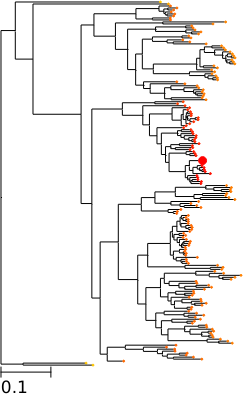

In [101]:
test_tree.render('%%inline', tree_style=ts)

## ENS-t-SNE per phylum

In [21]:
# clades with 1000 nodes
kilo_clades = 0
kilo_names = []
kilo_leaves = []
for node in gtdb_full.traverse('levelorder'):
    # num_leaves = len(node.get_leaves())
    # if num_leaves < 1100 and num_leaves > 900:
    #     kilo_clades += 1
    if 'c__' in names_map.loc[node.name]:
        kilo_leaves = list(set(kilo_leaves + [n.name for n in node.get_leaves()]))  
        

In [22]:
len(kilo_leaves)

62215

In [20]:
len(md_top_phyla['Class'].unique())

242

In [15]:
kilo_clades

46

In [65]:
names_map[names_map.str.contains('p__Proteobacteria')]

c006481    92.0:p__Proteobacteria
dtype: object

In [71]:
proteo_root = gtdb_full.search_nodes(name='c006481')[0]

In [ ]:
proteo_root.render('%%inline', tree_style=ts)

In [ ]:
print('test')

In [77]:
for node in list(proteo_root.traverse('levelorder'))[:20]:
    print(node.name, names_map.loc[node.name])
    print(len(node.get_leaves()))

c006481 92.0:p__Proteobacteria
17350
c008061 89.0
9616
c008062 76.0
7734
c009811 99.0:c__Gammaproteobacteria
9582
c009812 96.0:c__Zetaproteobacteria
34
c009813 100.0:c__Magnetococcia; o__Magnetococcales
50
c009814 93.0:c__Alphaproteobacteria
7684
c011769 100.0:o__Thiohalorhabdales; f__Thiohalorhabdaceae
2
c011770 76.0
9580
GB_GCA_001872725_1 GB_GCA_001872725.1
1
c011772 100.0:o__Mariprofundales
33
c011773 100.0:f__Magnetococcaceae
2
c011774 26.0
48
c011775 100.0:o__UBA1280
13
c011776 93.0
7671
RS_GCF_001399755_1 RS_GCF_001399755.1
1
GB_GCA_018609925_1 GB_GCA_018609925.1
1
c013845 67.0
9563
c013846 100.0:o__Acidithiobacillales
17
GB_GCA_015487905_1 GB_GCA_015487905.1
1


In [23]:
patristic_distance_matrix

NameError: name 'patristic_distance_matrix' is not defined

In [70]:
[len(b.get_leaves()) for b in gtdb_full.search_nodes(name='c006481')[0].get_children()]

[9616, 7734]

In [56]:
for phylum in md_top_phyla['Phylum'].unique():
    print(phylum)
    accs = md_top_phyla[md_top_phyla['Phylum'].eq(phylum)]['accession_reformat'].values
    # subset to ids in our data already
    ids = [i for i in accs if i in np_pca_data.index]
    print(len(accs), len(ids))

Proteobacteria
17350 16076
Bacteroidota
8588 7663
Firmicutes
4216 4029
Firmicutes_A
8243 7861
Desulfobacterota_I
236 221
Actinobacteriota
7328 7048
Patescibacteria
2485 222
Cyanobacteria
1372 1229
Verrucomicrobiota
1325 822
Bdellovibrionota
224 119
Firmicutes_B
323 253
Planctomycetota
1071 655
Chlamydiota
171 90
Myxococcota
393 359
Marinisomatota
186 31
Chloroflexota
1387 633
Campylobacterota
550 519
Desulfobacterota
939 489
Elusimicrobiota
189 84
Nitrospirota
314 93
Omnitrophota
282 38
Fibrobacterota
120 67
Spirochaetota
695 410
Acidobacteriota
873 710
Firmicutes_C
395 385
Firmicutes_G
131 76
Gemmatimonadota
237 223
Firmicutes_D
104 50
Synergistota
132 66
Armatimonadota
139 84
Deinococcota
144 140


In [55]:
for phylum in md_top_phyla['Phylum'].unique()[:1]:
    print(phylum)
    accs = md_top_phyla[md_top_phyla['Phylum'].eq(phylum)]['accession_reformat'].values
    # subset to ids in our data already
    ids = [i for i in accs if i in np_pca_data.index]
    print(len(accs), len(ids))
   
    
#     # vector of T/F for leaves in the trait data used to subset distance matrix
#     phylum_keep_rows = np.array([r in ids for r in row_names])

#     # same as above, used to reindex trait data
#     phylum_keep_rows_names = np.array([r for r in row_names if r in ids])
    
#     # 
#     phylum_dist_matrix = distance_matrix[phylum_keep_rows, :][:, phylum_keep_rows]
    
#     phylum_pca_data = np_pca_data.reindex(index=phylum_keep_rows_names).values
    
#     phylum_tsne = mview.mpse_tsne(data=[phylum_dist_matrix, phylum_pca_data],
#                      perplexity=500,
#                      iters=1000,
#                      smart_init=True,
#                      verbose=0,
#                      show_plots=True)

Proteobacteria
17350 16076


***mview.mpse_tsne()***
  mview.MPSE():
(51851, 51851)
(51851, 11)
    data details:
      number of perspectives : 2
      number of samples : 51851
    visualization details:
      embedding dimension : 3
      image dimension : 2
      visualization type : tsne
  setup visualization instance for perspective 1 :
      mview.TSNE():
len 1
        data details:
          number of samples : 51851
        embedding details:
          embedding dimension : 2
          perplexity : 500.00
        TSNE.initialize():
          method : random
          initial cost : 9.23e+00
  setup visualization instance for perspective 2 :
      mview.TSNE():
len 1
        data details:
          number of samples : 51851
        embedding details:
          embedding dimension : 2
          perplexity : 500.00
        TSNE.initialize():
          method : random
          initial cost : 9.26e+00
    initialize:
      fixed embedding : False
      initial embedding : random
      fixed projections : Fals

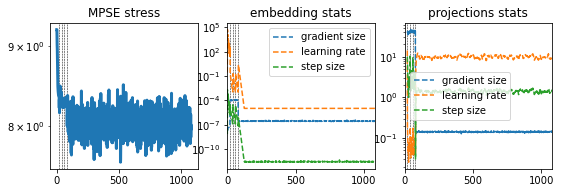

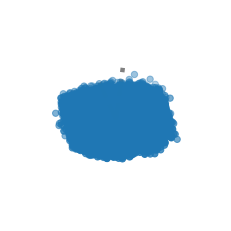

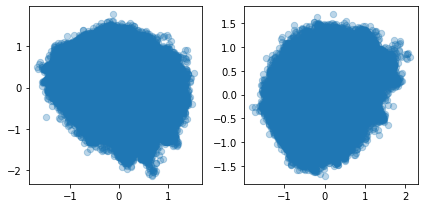

CPU times: user 1d 9h 31min 23s, sys: 1d 16h 54min 37s, total: 3d 2h 26min 1s
Wall time: 5h 38min 22s


In [136]:
%%time
data_tsne = mview.mpse_tsne(data=[patristic_distance_matrix, np_pca_data],
                     perplexity=500,
                     iters=1000,
                     smart_init=True,
                     verbose=1,
                     show_plots=True)

In [137]:
mpse_tsne_embedding = pd.DataFrame(index=keep_rows_names, data=data_tsne.embedding, columns=['dim1', 'dim2', 'dim3'])
mpse_tsne_embedding

dim1      dim2      dim3
GB_GCA_012517545_1 -0.002708 -0.496971 -0.373754
GB_GCA_017540815_1 -0.462411  0.669171 -0.324899
GB_GCA_001829125_1 -0.732017  0.687048 -1.010119
GB_GCA_009784515_1 -0.826977  0.763417 -0.372207
GB_GCA_016936615_1  0.197592  0.879629 -0.136358
...                      ...       ...       ...
GB_GCA_903959175_1 -0.854202 -0.919204 -0.038936
GB_GCA_903900265_1 -0.225495 -1.060629  0.272686
GB_GCA_903844155_1 -1.286639 -0.336116  0.013515
GB_GCA_009692605_1 -0.127219 -1.304199 -0.518487
GB_GCA_903875225_1 -0.686123 -1.067136 -0.739254

[51851 rows x 3 columns]

In [35]:
phylum_color_list = ['red', 'green', 'blue', 'gold', 'greenyellow', 'darkviolet', 'lightgray',
                     'darkred', 'brown', 'darkorange', 'chocolate', 'crimson', 'fuchsia', 'tomato',  'lightgreen', 'salmon',
                     'olive', 'mediumpurple',   'pink', 'violet', 'yellow', 
                     'darkslategrey', 'darkblue', 'dodgerblue',   'mediumturquoise', 'thistle', 'darkseagreen',
                       'y',  'paleturquoise', 'g', 'cyan', 'grey', ]

phylum_color_dict = dict(zip(md_top_phyla.set_index('accession_reformat').reindex(pca_data.index)['Phylum'].fillna('Small phylum').value_counts().index,
             phylum_color_list))

In [139]:
# with open('/data/mhoffert/fiererlab/periodic_phyla/results/20230302_pca_data.pickle', 'rb') as pca_handle:
#     pca_data = pickle.load(pca_handle)

In [140]:
md_top_phyla['accession']

0         GB_GCA_000012145.1
3         GB_GCA_000024525.1
6         GB_GCA_000169995.1
14        GB_GCA_000209515.2
26        GB_GCA_000238815.2
                 ...        
311412    RS_GCF_904063065.1
311425    RS_GCF_904846615.1
311456    RS_GCF_905220835.1
311469    RS_GCF_907164905.1
311479    RS_GCF_910593725.1
Name: accession, Length: 60142, dtype: object

In [141]:
md_top_phyla.set_index('accession_reformat') #.reindex(pca_data.index)['Phylum']

accession  ambiguous_bases  checkm_completeness  \
accession_reformat                                                             
GB_GCA_000012145_1  GB_GCA_000012145.1                0               100.00   
GB_GCA_000024525_1  GB_GCA_000024525.1                0               100.00   
GB_GCA_000169995_1  GB_GCA_000169995.1                0                96.26   
GB_GCA_000209515_2  GB_GCA_000209515.2                0                99.57   
GB_GCA_000238815_2  GB_GCA_000238815.2                0                99.56   
...                                ...              ...                  ...   
RS_GCF_904063065_1  RS_GCF_904063065.1                0               100.00   
RS_GCF_904846615_1  RS_GCF_904846615.1                0                99.86   
RS_GCF_905220835_1  RS_GCF_905220835.1                0                99.80   
RS_GCF_907164905_1  RS_GCF_907164905.1                0               100.00   
RS_GCF_910593725_1  RS_GCF_910593725.1                0                64.08   

                    checkm_contamination  checkm_marker_count  \
accession_reformat                                              
GB_GCA_000012145_1                  0.47                  324   
GB_GCA_000024525_1                  0.89                  454   
GB_GCA_000169995_1                  0.90                 1066   
GB_GCA_000209515_2                  2.16                  507   
GB_GCA_000238815_2                  0.00                  347   
...                                  ...                  ...   
RS_GCF_904063065_1                  0.81                  812   
RS_GCF_904846615_1                  0.27                  674   
RS_GCF_905220835_1                  0.38                  769   
RS_GCF_907164905_1                  0.60                  454   
RS_GCF_910593725_1                  0.00                  570   

                               checkm_marker_lineage  checkm_marker_set_count  \
accession_reformat                                                              
GB_GCA_000012145_1        o__Rickettsiales (UID3809)                      211   
GB_GCA_000024525_1         o__Cytophagales (UID2936)                      336   
GB_GCA_000169995_1               g__Vibrio (UID4874)                      378   
GB_GCA_000209515_2  c__Gammaproteobacteria (UID4444)                      232   
GB_GCA_000238815_2  c__Alphaproteobacteria (UID3305)                      229   
...                                              ...                      ...   
RS_GCF_904063065_1      o__Pseudomonadales (UID4488)                      308   
RS_GCF_904846615_1      o__Pseudomonadales (UID4679)                      364   
RS_GCF_905220835_1         g__Burkholderia (UID4006)                      248   
RS_GCF_907164905_1         o__Cytophagales (UID2936)                      336   
RS_GCF_910593725_1      o__Burkholderiales (UID4001)                      250   

                    checkm_strain_heterogeneity  coding_bases  coding_density  \
accession_reformat                                                              
GB_GCA_000012145_1                          0.0       1344326       84.695824   
GB_GCA_000024525_1                         25.0       7481814       88.111962   
GB_GCA_000169995_1                         25.0       4995414       85.600748   
GB_GCA_000209515_2                         25.0       2656553       88.034564   
GB_GCA_000238815_2                          0.0       2254256       91.675739   
...                                         ...           ...             ...   
RS_GCF_904063065_1                          0.0       4417451       88.289178   
RS_GCF_904846615_1                          0.0       2741819       82.852233   
RS_GCF_905220835_1                          0.0       7043963       86.032926   
RS_GCF_907164905_1                          0.0       6480666       89.663361   
RS_GCF_910593725_1                          0.0        767513       64.157503   

                    ...  trna_aa_c

In [36]:
phylum_color_dict = dict(zip(md_top_phyla.set_index('accession_reformat').reindex(pca_data.index)['Phylum'].fillna('Small phylum').value_counts().index,
             phylum_color_list))

In [143]:
phylum_color_dict

{'Proteobacteria': 'red',
 'Firmicutes_A': 'green',
 'Bacteroidota': 'blue',
 'Actinobacteriota': 'gold',
 'Firmicutes': 'greenyellow',
 'Cyanobacteria': 'darkviolet',
 'Small phylum': 'lightgray',
 'Verrucomicrobiota': 'darkred',
 'Acidobacteriota': 'brown',
 'Planctomycetota': 'darkorange',
 'Chloroflexota': 'chocolate',
 'Campylobacterota': 'crimson',
 'Desulfobacterota': 'fuchsia',
 'Spirochaetota': 'tomato',
 'Firmicutes_C': 'lightgreen',
 'Myxococcota': 'salmon',
 'Firmicutes_B': 'olive',
 'Gemmatimonadota': 'mediumpurple',
 'Patescibacteria': 'pink',
 'Desulfobacterota_I': 'violet',
 'Deinococcota': 'yellow',
 'Bdellovibrionota': 'darkslategrey',
 'Nitrospirota': 'darkblue',
 'Chlamydiota': 'dodgerblue',
 'Armatimonadota': 'mediumturquoise',
 'Elusimicrobiota': 'thistle',
 'Firmicutes_G': 'darkseagreen',
 'Fibrobacterota': 'y',
 'Synergistota': 'paleturquoise',
 'Firmicutes_D': 'g',
 'Omnitrophota': 'cyan',
 'Marinisomatota': 'grey'}

In [144]:
md_top_phyla['accession_reformat'] = md_top_phyla['accession'].apply(lambda x: x.replace('.', '_'))

In [145]:
mpse_plot_data = mpse_tsne_embedding.sort_values('dim1')

### Coloring by phylum

In [146]:
mpse_plot_data

dim1      dim2      dim3
RS_GCF_011764425_1 -1.627638  0.062185  0.399808
RS_GCF_004359545_1 -1.610524  0.339999 -0.062074
RS_GCF_016785085_1 -1.591839 -0.033237  0.256551
RS_GCF_000986795_1 -1.566982  0.192919  0.289977
RS_GCF_002901945_1 -1.553048  0.333978  0.176458
...                      ...       ...       ...
RS_GCF_014851585_1  1.451223 -0.236604  0.021449
RS_GCF_900016785_1  1.454661 -0.246280 -0.235329
GB_GCA_016938035_1  1.458176 -0.110281 -0.401721
RS_GCF_000520735_1  1.501973  0.667642 -0.600735
GB_GCA_001775445_1  1.525436  0.459907 -0.248597

[51851 rows x 3 columns]

In [147]:
hues = md_top_phyla.set_index('accession_reformat').reindex([s for s in mpse_plot_data.index])['Phylum'].values
hues = [p if p in phylum_color_dict.keys() else 'Small phylum' for p in hues]

In [148]:
np.unique(hues)

array(['Acidobacteriota', 'Actinobacteriota', 'Armatimonadota',
       'Bacteroidota', 'Bdellovibrionota', 'Campylobacterota',
       'Chlamydiota', 'Chloroflexota', 'Cyanobacteria', 'Deinococcota',
       'Desulfobacterota', 'Desulfobacterota_I', 'Elusimicrobiota',
       'Fibrobacterota', 'Firmicutes', 'Firmicutes_A', 'Firmicutes_B',
       'Firmicutes_C', 'Firmicutes_D', 'Firmicutes_G', 'Gemmatimonadota',
       'Marinisomatota', 'Myxococcota', 'Nitrospirota', 'Omnitrophota',
       'Patescibacteria', 'Planctomycetota', 'Proteobacteria',
       'Small phylum', 'Spirochaetota', 'Synergistota',
       'Verrucomicrobiota'], dtype='<U18')

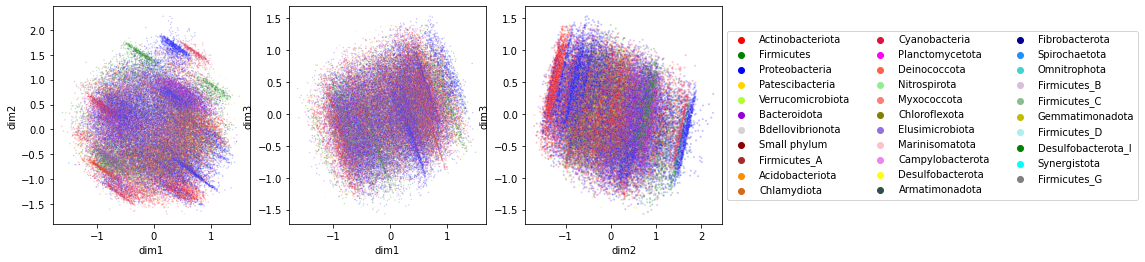

In [149]:
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1,3,1)
sns.scatterplot(data=mpse_plot_data, x='dim1', y='dim2', s=2, alpha=0.25, hue=hues, palette=phylum_color_list)
ax.get_legend().remove()

ax = fig.add_subplot(1,3,2)
sns.scatterplot(data=mpse_plot_data, x='dim1', y='dim3', s=2, alpha=0.25, hue=hues, palette=phylum_color_list)
# lgd = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), facecolor='white')
ax.get_legend().remove()

ax = fig.add_subplot(1,3,3)
sns.scatterplot(data=mpse_plot_data, x='dim2', y='dim3', s=4, alpha=0.25, hue=hues, palette=phylum_color_list)
lgd = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), facecolor='white', ncol=3)
# plt.savefig('/data/mhoffert/fiererlab/periodic_phyla/results/20230816_enstsne_perp1000_iter2000.png', dpi=400, bbox_inches='tight')

### Testing code

In [305]:
len(np_pca_data)

50745

In [321]:
random_indeces = np.random.randint(0, len(np_pca_data), 5000)

In [322]:
patristic_distance_matrix[random_indeces, :][:, random_indeces]

array([[0.     , 2.46998, 2.33528, ..., 2.33407, 1.35964, 2.15251],
       [2.46998, 0.     , 2.4926 , ..., 2.49139, 3.03128, 2.01987],
       [2.33528, 2.4926 , 0.     , ..., 0.93075, 2.89658, 2.17513],
       ...,
       [2.33407, 2.49139, 0.93075, ..., 0.     , 2.89537, 2.17392],
       [1.35964, 3.03128, 2.89658, ..., 2.89537, 0.     , 2.71381],
       [2.15251, 2.01987, 2.17513, ..., 2.17392, 2.71381, 0.     ]],
      dtype=float32)

***mview.mpse_tsne()***
  mview.MPSE():
(5000, 5000)
(5000, 11)
    data details:
      number of perspectives : 2
      number of samples : 5000
    visualization details:
      embedding dimension : 3
      image dimension : 2
      visualization type : tsne
  setup visualization instance for perspective 1 :
      mview.TSNE():
len 1
        data details:
          number of samples : 5000
        embedding details:
          embedding dimension : 2
          perplexity : 2500.00
        TSNE.initialize():
          method : random
          initial cost : 1.44e+00
  setup visualization instance for perspective 2 :
      mview.TSNE():
len 1
        data details:
          number of samples : 5000
        embedding details:
          embedding dimension : 2
          perplexity : 2500.00
        TSNE.initialize():
          method : random
          initial cost : 1.37e+00
    initialize:
      fixed embedding : False
      initial embedding : random
      fixed projections : False
  

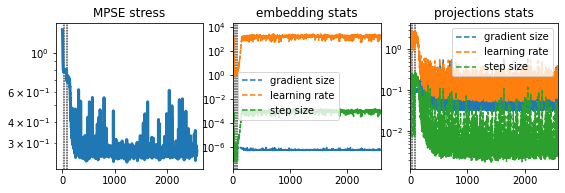

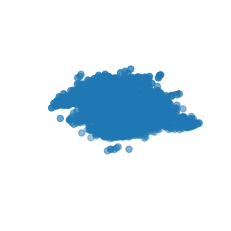

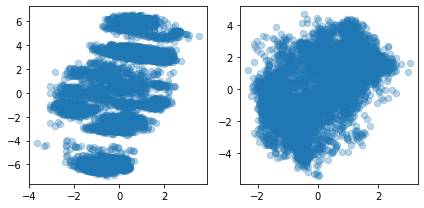

CPU times: user 2h 33min 6s, sys: 2h 38min 28s, total: 5h 11min 34s
Wall time: 23min 57s


In [323]:
%%time
test_tsne = mview.mpse_tsne(data=[patristic_distance_matrix[random_indeces, :][:, random_indeces], 
                                  np_pca_data[random_indeces, :]],
                     perplexity=2500,
                     iters=2500,
                     smart_init=True,
                     verbose=1,
                     show_plots=True)

In [324]:
test_tsne_embedding = pd.DataFrame(index=[keep_rows_names[i] for i in random_indeces], data=test_tsne.embedding, columns=['dim1', 'dim2', 'dim3'])
test_tsne_embedding

test_plot_data = test_tsne_embedding.sort_values('dim1')


In [330]:
hues = md_top_phyla.set_index('accession_reformat').reindex([s for s in test_plot_data.index])['Phylum'].values
hues = [p if p in phylum_color_dict.keys() else 'Small phylum' for p in hues]

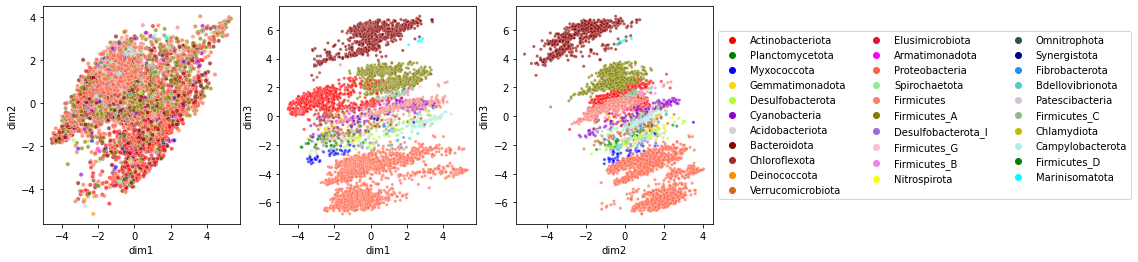

In [333]:
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1,3,1)

size=10
alpha=0.65
# selected = ['Proteobacteria', 'Firmicutes', 'Firmicutes_A', 'Bacteroidota', 'Chlamydiota', 'Actinobacteriota']
# hues = [h if h in selected else 'other' for h in hues ]
sns.scatterplot(data=test_plot_data, x='dim1', y='dim2', size=size, alpha=alpha, hue=hues, palette=phylum_color_list[:len(np.unique(hues))])
ax.get_legend().remove()

ax = fig.add_subplot(1,3,2)
sns.scatterplot(data=test_plot_data, x='dim1', y='dim3', s=size, alpha=alpha, hue=hues, palette=phylum_color_list[:len(np.unique(hues))])
# lgd = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), facecolor='white')
ax.get_legend().remove()

ax = fig.add_subplot(1,3,3)
sns.scatterplot(data=test_plot_data, x='dim2', y='dim3', s=size, alpha=alpha, hue=hues, palette=phylum_color_list[:len(np.unique(hues))])
lgd = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), facecolor='white', ncol=3)
# plt.savefig('/data/mhoffert/fiererlab/periodic_phyla/results/20230816_enstsne_perp1000_iter2000.png', dpi=400, bbox_inches='tight')

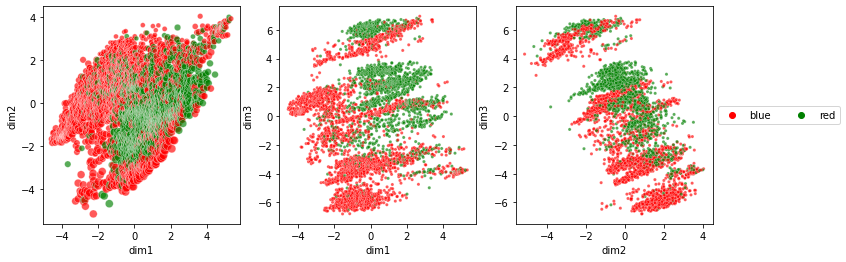

In [334]:
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1,3,1)

size=10
alpha=0.65
# selected = ['Proteobacteria', 'Firmicutes', 'Firmicutes_A', 'Bacteroidota', 'Chlamydiota', 'Actinobacteriota']
hues = ['blue' if pca_data.loc[t, 'aerobe'] > 0.5 else 'red' for t in test_plot_data.index]
sns.scatterplot(data=test_plot_data, x='dim1', y='dim2', size=test_plot_data['dim3'], alpha=alpha, hue=hues, palette=phylum_color_list[:len(np.unique(hues))])
ax.get_legend().remove()

ax = fig.add_subplot(1,3,2)
sns.scatterplot(data=test_plot_data, x='dim1', y='dim3', s=size, alpha=alpha, hue=hues, palette=phylum_color_list[:len(np.unique(hues))])
# lgd = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), facecolor='white')
ax.get_legend().remove()

ax = fig.add_subplot(1,3,3)
sns.scatterplot(data=test_plot_data, x='dim2', y='dim3', s=size, alpha=alpha, hue=hues, palette=phylum_color_list[:len(np.unique(hues))])
lgd = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), facecolor='white', ncol=3)
# plt.savefig('/data/mhoffert/fiererlab/periodic_phyla/results/20230816_enstsne_perp1000_iter2000.png', dpi=400, bbox_inches='tight')

Text(0.5, 0, 'dim3')

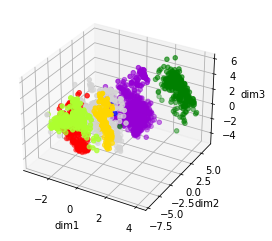

In [312]:
fig = plt.figure()
unique_hues = list(np.unique(hues))
unique_colors = phylum_color_list[:len(np.unique(hues))]
ax = fig.add_subplot(projection='3d')
ax.scatter(test_plot_data['dim1'], 
           test_plot_data['dim2'], 
           test_plot_data['dim3'],
           c=[unique_colors[unique_hues.index(h)] for h in hues])
ax.set_xlabel('dim1')
ax.set_ylabel('dim2')
ax.set_zlabel('dim3')

### Testing Clustering

In [313]:
test_clustermap = pd.DataFrame(index=[keep_rows_names[i] for i in random_indeces],
                               columns=[keep_rows_names[i] for i in random_indeces],
                               data=patristic_distance_matrix[random_indeces, :][:, random_indeces])

In [314]:
phyl2hue = dict(zip(np.unique(hues), phylum_color_list[:len(np.unique(hues))]))

In [315]:
phyl2hue

{'Actinobacteriota': 'red',
 'Bacteroidota': 'green',
 'Chlamydiota': 'blue',
 'Firmicutes': 'gold',
 'Firmicutes_A': 'greenyellow',
 'Proteobacteria': 'darkviolet',
 'other': 'lightgray'}

In [316]:
%%time
random_index_names = [keep_rows_names[i] for i in random_indeces]
phylum_names = [md_top_phyla.set_index('accession_reformat').loc[i, 'Phylum'] for i in random_index_names]
row_colors = pd.Series(index=random_index_names,
                     data=[phyl2hue[p] for p in phylum_names])

KeyError: 'Acidobacteriota'

In [317]:
from matplotlib.colors import to_rgba

In [318]:
row_colors = row_colors.apply(to_rgba)

In [319]:
g = sns.clustermap(test_clustermap, 
                   row_colors = row_colors,
                   figsize=(12,12))
g.ax_cbar.remove()
g.ax_col_dendrogram.remove()

reindexing with a non-unique Index is deprecated and will raise in a future version.


ValueError: cannot reindex on an axis with duplicate labels

<Figure size 864x864 with 0 Axes>

In [270]:
pca_clustermap = pd.DataFrame(index=[keep_rows_names[i] for i in random_indeces],
                                data=np_pca_data[random_indeces, :])

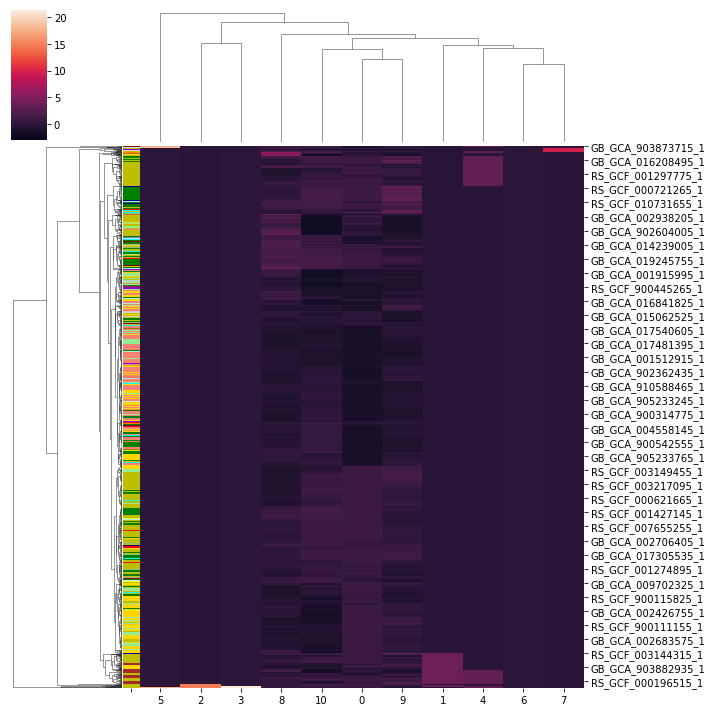

In [271]:
sns.clustermap(pca_clustermap, row_colors=row_colors)

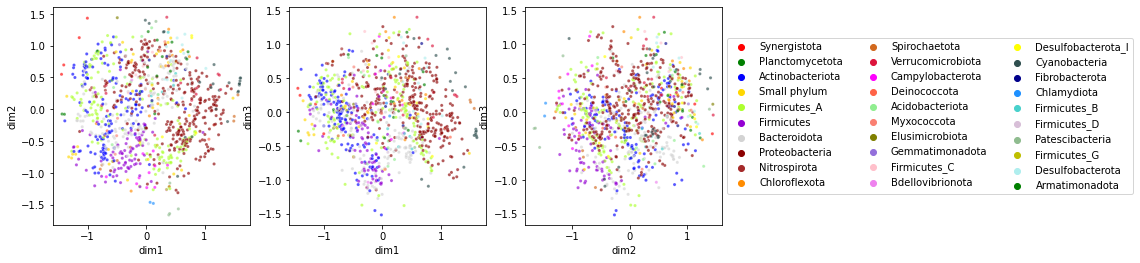

In [181]:
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1,3,1)

size=10
alpha=0.65

sns.scatterplot(data=test_plot_data, x='dim1', y='dim2', s=size, alpha=alpha, hue=hues, palette=phylum_color_list[:len(np.unique(hues))])
ax.get_legend().remove()

ax = fig.add_subplot(1,3,2)
sns.scatterplot(data=test_plot_data, x='dim1', y='dim3', s=size, alpha=alpha, hue=hues, palette=phylum_color_list[:len(np.unique(hues))])
# lgd = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), facecolor='white')
ax.get_legend().remove()

ax = fig.add_subplot(1,3,3)
sns.scatterplot(data=test_plot_data, x='dim2', y='dim3', s=size, alpha=alpha, hue=hues, palette=phylum_color_list[:len(np.unique(hues))])
lgd = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), facecolor='white', ncol=3)
# plt.savefig('/data/mhoffert/fiererlab/periodic_phyla/results/20230816_enstsne_perp1000_iter2000.png', dpi=400, bbox_inches='tight')

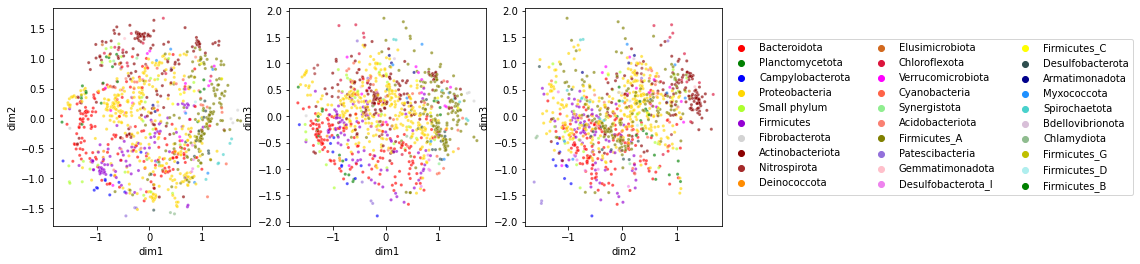

In [173]:
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1,3,1)

size=10
alpha=0.65

sns.scatterplot(data=test_plot_data, x='dim1', y='dim2', s=size, alpha=alpha, hue=hues, palette=phylum_color_list[:len(np.unique(hues))])
ax.get_legend().remove()

ax = fig.add_subplot(1,3,2)
sns.scatterplot(data=test_plot_data, x='dim1', y='dim3', s=size, alpha=alpha, hue=hues, palette=phylum_color_list[:len(np.unique(hues))])
# lgd = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), facecolor='white')
ax.get_legend().remove()

ax = fig.add_subplot(1,3,3)
sns.scatterplot(data=test_plot_data, x='dim2', y='dim3', s=size, alpha=alpha, hue=hues, palette=phylum_color_list[:len(np.unique(hues))])
lgd = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), facecolor='white', ncol=3)
# plt.savefig('/data/mhoffert/fiererlab/periodic_phyla/results/20230816_enstsne_perp1000_iter2000.png', dpi=400, bbox_inches='tight')

### Retrying clustering based on phylogeny + data

In [336]:
gtdb_full = Tree('/data/mhoffert/genomes/GTDB_r207/tree/bac120_r207.tree', format=1, quoted_node_names=True)

### Reformatting tree

In [338]:
# rename internal nodes
names_map = []
i = 0
for node in gtdb_full.traverse(strategy='levelorder'):
    if i % 500 == 0:
        display(i)
        clear_output(wait=True)
    if not node.is_leaf():
        new_node_name = f'c{i:06}'
        names_map.append((new_node_name, node.name))
        node.name = new_node_name
    else:
        names_map.append((node.name.replace('.', '_'), node.name))
        node.name = node.name.replace('.', '_')
    i += 1

124500

In [339]:
# make a series
names_map = pd.Series(dict(names_map))

In [357]:
# slicing pca data
(pd.cut(pca_data['aerobe'].head(2), [0, 0.25, 0.5, 0.75, 1]).value_counts() > 0).sum() > 1

True

In [343]:
clustering_pca_data = pca_data.copy(deep=True)

In [344]:
clustering_pca_data

aerobe  phototroph  3HP bicycle  3HP/4HB  Calvin Cycle  \
GB_GCA_000007325_1  0.001817           0          0.0      0.0           0.0   
GB_GCA_000008885_1  0.470498           0          0.0      0.0           0.0   
GB_GCA_000009845_1  0.682832           0          0.0      0.0           0.0   
GB_GCA_000010085_1  0.865893           0          0.0      0.0           0.0   
GB_GCA_000010565_1  0.018416           0          0.0      0.0           0.0   
...                      ...         ...          ...      ...           ...   
RS_GCF_907165215_1  0.987057           0          0.0      0.0           0.0   
RS_GCF_910593725_1  0.275134           0          0.0      0.0           0.0   
RS_GCF_910593785_1  0.946832           0          0.0      0.0           0.0   
RS_GCF_910593845_1  0.971290           0          0.0      0.0           0.0   
RS_GCF_910594985_1  0.956487           0          0.0      0.0           0.0   

                    rAcoA homoacetogenic  rTCA I  rTCA II  growth_rate  \
GB_GCA_000007325_1                   0.0     0.0      0.0     9.686217   
GB_GCA_000008885_1                   0.0     0.0      0.0    10.395816   
GB_GCA_000009845_1                   0.0     0.0      0.0    11.625192   
GB_GCA_000010085_1                   0.0     0.0      0.0     1.253937   
GB_GCA_000010565_1                   0.0     0.0      0.0     4.432701   
...                                  ...     ...      ...          ...   
RS_GCF_907165215_1                   0.0     0.0      0.0     4.458259   
RS_GCF_910593725_1                   0.0     0.0      0.0     6.484906   
RS_GCF_910593785_1                   0.0     0.0      0.0     5.998208   
RS_GCF_910593845_1                   0.0     0.0      0.0     0.476456   
RS_GCF_910594985_1                   0.0     0.0      0.0     1.099750   

                    genome_size  gc_percentage  
GB_GCA_000007325_1      2174500      27.151588  
GB_GCA_000008885_1       703004      22.475121  
GB_GCA_000009845_1       853092      27.759941  
GB_GCA_000010085_1      4292502      54.504948  
GB_GCA_000010565_1      3025375      52.961104  
...                         ...            ...  
RS_GCF_907165215_1      4109925      61.042313  
RS_GCF_910593725_1      1196295      42.463356  
RS_GCF_910593785_1      2865069      69.471967  
RS_GCF_910593845_1      7609664      53.979439  
RS_GCF_910594985_1      8178005      51.194005  

[51851 rows x 11 columns]

In [345]:
gtdb_clustering = gtdb_full.copy()

In [347]:
no_prune = []
for node in gtdb_full.traverse('levelorder'):
    if node.is_leaf() and node.name in pca_data.index:
        no_prune.append(node)

In [349]:
gtdb_clustering.prune([l.name for l in no_prune], preserve_branch_length=True)


In [350]:
gtdb_clustering.describe()

Number of leaf nodes:	51851
Total number of nodes:	103701
Rooted:	Yes
Most distant node:	RS_GCF_001645765_1
Max. distance:	2.977830


In [354]:
cut_dict = {
    'aerobe':[0,0.5,1],
     'phototroph':[0,0.5,1],
    '3HP bicycle':[0,0.5,1],
    '3HP/4HB':[0,0.5,1],
    'Calvin Cycle':[0,0.5,1],
    'rAcoA homoacetogenic':[0,0.5,1], 
    'rTCA I':[0,0.5,1],
    'rTCA II':[0,0.5,1],
    'growth_rate':[0,1,5,10,50],
    'genome_size':[0,0.5e6,1e6,5e6,10e6,20e6],
    'gc_percentage':[0,25,50,75,100],
}

def is_consistent_group(df):
    for col in df.columns:
        if (pd.cut(df[col], cut_dict[col]).value_counts() > 0).sum() > 1:
            return False
    return True

In [364]:
import time

In [371]:
def collapseTree(tree, data): # add to ete utils
    #is there a better way to collapse that preserves properties?
    t = Tree(tree.write(is_leaf_fn=lambda n: collapseClades(data, n), format=3),format=3) 
    t.name = tree.name
    return t

def collapseClades(df, node):
    '''collapses clades below max_leaf_dist. can be passed as is_leaf_fn'''
    #print(node.name)
    if node.is_leaf():
        #print('is leaf')
        return True
    else:
        return is_consistent_group(df.reindex([l.name for l in node.get_leaves()]))

In [377]:
collapsed = collapseTree(gtdb_clustering.get_children()[0], pca_data)

In [378]:
collapsed.describe()

Number of leaf nodes:	242
Total number of nodes:	483
Rooted:	Yes
Most distant node:	GB_GCA_017453705_1
Max. distance:	1.668950


In [ ]:
collapsed.render('%%inline')

qt.qpa.screen: QXcbConnection: Could not connect to display 
Could not connect to any X display.


In [1]:
print('test')

test


In [380]:
gtdb_clustering.get_children()[0].describe()

Number of leaf nodes:	410
Total number of nodes:	819
Rooted:	Yes
Most distant node:	GB_GCA_902773355_1
Max. distance:	1.670650


In [376]:
len(gtdb_clustering.get_children()[0].get_leaves())

410

In [367]:
unflagged = list([l.name for l in gtdb_clustering.get_leaves()])
flagged = []
for node in gtdb_clustering.traverse('levelorder'):
    print(node.name)
    if not node.is_leaf():
        leaves = list([l.name for l in node.get_leaves()])
        data = pca_data.reindex(leaves)
        if is_consistent_group(data):
            print(node.name)
            flagged += list(set(flagged + leaves))
            unflagged = [l for l in unflagged if not l in flagged]

        display(len(unflagged), len(flagged))
        clear_output(wait=True)
    
    

c004112
c004112


KeyboardInterrupt: 

In [368]:
len(flagged)

5200

In [369]:
len(unflagged)

51716